# Analyse cartes cognitives

Version définitive, pour thèse VB et rapport final CNRT.

Voir rendu sur <https://nbviewer.org/github/romulusFR/cnrt_cartes_cog/blob/main/cogmaps_v3/analyse_chapitre_these.ipynb>


## Chargement et préparation du jeu de données

Les données sont stockées dans un fichier `.xls` dans le sous dossier `../input/`.
Il faut transformer l'onglet `BDD` pour le mettre dans un format manipulable.


In [1]:
import operator as op
from collections import defaultdict
from itertools import pairwise

from datetime import date
from pathlib import Path
from pprint import pprint, pformat
from collections import Counter
from statistics import fmean, median
import warnings

# cracra mais on va faire avec
warnings.filterwarnings("ignore")

import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from IPython.display import display

from catk import CA  # type: ignore


# nombre max de mots énoncables = nb colonnes source XLS
MAX_COLS = 20
# fichier BDD
# XLS_SOURCE = Path("../input/BDD_2022-06-22.xlsx")
XLS_SOURCE = Path("../input/BDD_2023-07-20.xlsx")

# Noms des onglets
SHEET_THESAURUS = "Thésaurus"
SHEET_BDD = "BDD"
SHEET_QUESTIONS = "Questions"
SHEET_MOTS = "Mots"

# préfixes des colonnes des mots énoncés
PREFIX_MINE = "Mine"
PREFIX_FUTUR = "Futur"

# noms des cartes
LABEL_MINE = "la mine et le nickel"
LABEL_FUTUR = "la mine dans le futur"

TOP_K_WORDS = 20

# mots sans signification, supprimés du thésaurus
INCONNU = "S.i"

# résultats
OUTPUT_FOLDER = Path("../output_v3")
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

TODAY = date.today().strftime("%Y-%m-%d")

# categories de colonnes dans la BDD : quetionnaire mine, questionnaire futur et informations censurées
# le reste sont les attributs des répondants qu'on utilise dans la suite
cols_mine = [f"{PREFIX_MINE} {i}" for i in range(1, MAX_COLS + 1)]
cols_futur = [f"{PREFIX_FUTUR} {i}" for i in range(1, MAX_COLS + 1)]
cols_censurees = [f"Question {x}" for x in [2, 5.1, 7, 10.1, 11, 14, 14.1]] + ["Commentaire entretien/individu"]


# petit outillage
def clean(s: str) -> str:
    """Nettoyage de chaines"""
    if not isinstance(s, str):
        raise TypeError(f"'{s}' is of type {type(s)}")
    return s.strip().lower()


def pretty_pvals(x):
    """Affichage de courtoisie des niveaux de significativité statistique"""
    if x < 1e-4:
        return "****"
    if x < 1e-3:
        return "***"
    if x < 1e-2:
        return "**"
    if x < 5e-2:
        return "*"
    return ""


'/home/romulus/Documents/unc-scopus-bibliographer/pharmaco-chemistry-biblio/catk/catk/data/data.py' loaded
'/home/romulus/Documents/unc-scopus-bibliographer/pharmaco-chemistry-biblio/catk/catk/data/__init__.py' loaded
'/home/romulus/Documents/unc-scopus-bibliographer/pharmaco-chemistry-biblio/catk/catk/ca.py' loaded
'/home/romulus/Documents/unc-scopus-bibliographer/pharmaco-chemistry-biblio/catk/catk/__init__.py' loaded


### Chargement des données

In [2]:
df_complete = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_BDD, index_col="Numéro")


# ajout des groupes d'ages quinquennaux/décénaux GAD et GAQ
# df_complete["GAD"] = 10 * (df_complete["Question 12"] // 10)
def float_to_inter(f):
    if not np.isfinite(f):
        return f
    return f"{int(f)}-{int(f)+9} ans"

df_complete["GAD"] = [float_to_inter(base_age) for base_age in 10 * (df_complete["Question 12"] // 10)]
# df_complete["GAQ"] = 5 * (df_complete["Question 12"] // 5)

# print(f"Liste des colonnes disponibles dans l'onglet '{SHEET_BDD}' du fichier '{XLS_SOURCE}'")
# display(df_complete.columns)

# les informations des répondants
cols_resp = [c for c in df_complete.columns if c not in cols_mine + cols_futur + cols_censurees]

df_resp = df_complete[cols_resp]
df_resp.name = "Données personnelles"
df_mine = df_complete[cols_mine].astype("string")
df_mine.name = f"Cartes cognitives '{LABEL_MINE}'"
df_futur = df_complete[cols_futur].astype("string")
df_futur.name = f"Cartes cognitives '{LABEL_FUTUR}'"

print(f"Nombre de répondants {len(df_complete)}")
# print(f"Colonnes '{LABEL_MINE}' présentes {set(cols_mine) <= set(df_complete.columns)}")
# print(f"Colonnes '{LABEL_FUTUR}' présentes {set(cols_futur) <= set(df_complete.columns)}")

df_complete


Nombre de répondants 508


,Date,Commune d’enquête,Collecte directe,Commentaire entretien/individu,Question 1,Question 2,Question 3,Question 4,Question 5,Question 5.1,...,Futur 12,Futur 13,Futur 14,Futur 15,Futur 16,Futur 17,Futur 18,Futur 19,Futur 20,GAD
Numéro,,,,,,,,,,,,,,,,,,,,,
1,2021-06-09,Thio,Oui,NaN,Non,NaN,NaN,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50-59 ans
2,2021-06-09,Thio,Oui,Très bavard. Directeur du collège public.,Non,NaN,NaN,Non,Non,France (naissance),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60-69 ans
3,2021-06-09,Thio,Oui,NaN,Non,NaN,NaN,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30-39 ans
4,2021-06-09,Thio,Oui,NaN,Oui,Géomètre - topographe,15 ans,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50-59 ans
5,2021-06-10,Thio,Oui,NaN,Non,NaN,NaN,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60-69 ans
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2022-03-10,Hienghène,Oui,Collègien Hienghène,Non,NaN,NaN,Non,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10-19 ans
505,2022-03-10,Hienghène,Oui,Collègien Hienghène,Non,NaN,NaN,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10-19 ans
506,2022-03-10,Hienghène,Oui,Collègien Hienghène,Non,NaN,NaN,Oui,Oui,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10-19 ans


### Informations personnelles des répondants

On utilise l'onglet qui décrit les questions posées aux répondants. 

In [3]:
df_questions = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_QUESTIONS, parse_dates=False).astype(
    {"Question": "string", "Libellé": "string"}
)

print(
    f"Toutes les questions posées bien présentes chez les répondants {set(df_questions['Question']) <= (set(df_resp.columns) | set(cols_censurees))}"
)
display(df_questions)

# mise sous forme de dictionnaire pour remplacer les questions par leurs labels dans les résultats/légendes
questions_labels = df_questions.set_index("Question").to_dict()["Libellé"]  # orient="series"


Toutes les questions posées bien présentes chez les répondants True


,Question,Libellé
0,Question 1,Travaillez-vous ou avez travaillez pour l’indu...
1,Question 2,"Si oui, quel(s) étai(en)t votre/vos poste(s) ?"
2,Question 3,Depuis combien de temps travaillez-vous ou pen...
3,Question 4,Un membre de votre famille travaille t’il ou a...
4,Question 5,Avez-vous toujours vécu en Nouvelle-Calédonie ?
5,Question 5.1,"Si non, d’où venez-vous ?"
6,Question 6,"Si non, depuis combien de temps vivez-vous en ..."
7,Question 7,"Si non, pourquoi vous êtes vous installé(e) en..."
8,Question 8,Où habitez-vous ? (Le plus précis possible san...
9,Question 8.1,Commune de résidence.


### Division du jeu de données

Création des dictionnaires de réponses. On va extraire trois jeux de données :

- `cg_mine` : toutes les réponses aux questions "la mine", enquêtes 2021 **et** 2022
- `cg_mine_2022` : les 104 dernières réponses aux questions "la mine", enquête 2022
- `cg_futur_2022` : les 104 dernières réponses aux questions "la mine dans le futur", enquête 2022

On done quelques statistiques de base pour chaque jeu de données.


In [4]:
def get_cogmaps(df, cols):
    """fonction outil pour transformer le dataframe BDD en dictionnaire des mots énoncés"""
    return {idx: [clean(val) for val in vals.dropna().tolist()] for idx, vals in df[cols].astype("string").iterrows()}

# la restriction à l'année 2022
df_2022 = df_complete[df_complete["Date"].dt.year == 2022]

# les dictionnaires principaux : les Cartes Cognitives
# dictionnaires de la forme : { répondant, list[mots]}
cg_mine_tous = get_cogmaps(df_complete, cols_mine)
cg_mine_2022 = get_cogmaps(df_2022, cols_mine)
cg_futur_2022 = get_cogmaps(df_2022, cols_futur)

CGS = [cg_mine_tous, cg_mine_2022, cg_futur_2022]
PRE_LABELS = [(LABEL_MINE, "tous"), (LABEL_MINE, "2022"), (LABEL_FUTUR, "2022")]
LABELS = [f"{b} ({y})" for b, y in PRE_LABELS]


for cg, lbl in zip(CGS, LABELS):
    print(lbl.capitalize())
    print(f"  nombre de réponses {len(cg)}")
    print(f"  plus longue cartes {max(len(val) for val in cg.values())}")
    print(f"  longueur moyenne des cartes {fmean(len(val) for val in cg.values()):.2f}")
    print(f"  nombre total de mots énoncés {sum(len(val) for val in cg.values())}")
    print(f"  nombre de mots énoncés différents {len(set(v for val in cg.values() for v in val))}")
    print()



La mine et le nickel (tous)
  nombre de réponses 508
  plus longue cartes 20
  longueur moyenne des cartes 7.61
  nombre total de mots énoncés 3865
  nombre de mots énoncés différents 902

La mine et le nickel (2022)
  nombre de réponses 104
  plus longue cartes 20
  longueur moyenne des cartes 6.84
  nombre total de mots énoncés 711
  nombre de mots énoncés différents 335

La mine dans le futur (2022)
  nombre de réponses 104
  plus longue cartes 15
  longueur moyenne des cartes 3.43
  nombre total de mots énoncés 357
  nombre de mots énoncés différents 262



In [6]:
# création des des résumés "positions", qui donnent aussi le nombre de mot
def get_positions(cg: dict[str, list[int]]):
    res = defaultdict(list)
    for i, ws in cg.items():
        for p, w in enumerate(ws):
            # res[w].append(p + 1) # positions absolues
            res[w].append((len(ws) - p) / len(ws)) # positions relatives, en % le la longueur de la carte
    return res


# une position est dictionnaires de la forme : { mot, list[position]}
pos_mine_tous = get_positions(cg_mine_tous)
pos_mine_2022 = get_positions(cg_mine_2022)
pos_futur_2022 = get_positions(cg_futur_2022)

POS = [pos_mine_tous, pos_mine_2022, pos_futur_2022]

# len(pos_mine_tous["nickel"])
print("Position relative maximum, moyenne, mediane et minimum de chaque mot")
for w, ps in pos_mine_2022.items():
    print(f"\t{w} ({len(ps)}): {max(ps):.0%}, {fmean(ps):.0%}, {median(ps):.0%}, {min(ps):.0%}")


Position relative maximum, moyenne, mediane et minimum de chaque mot
	environnement (6): 100%, 80%, 76%, 50%
	destruction environnement (1): 90%, 90%, 90%, 90%
	industriel (1): 80%, 80%, 80%, 80%
	boue (1): 70%, 70%, 70%, 70%
	détruire (1): 60%, 60%, 60%, 60%
	poussière (1): 50%, 50%, 50%, 50%
	salissant (1): 40%, 40%, 40%, 40%
	destruction montagne (1): 30%, 30%, 30%, 30%
	prise de conscience (1): 20%, 20%, 20%, 20%
	reboisement (2): 25%, 18%, 18%, 10%
	destruction de la nature (1): 75%, 75%, 75%, 75%
	richesse (6): 100%, 67%, 76%, 11%
	gagne-pain (1): 25%, 25%, 25%, 25%
	rapporte beaucoup (1): 100%, 100%, 100%, 100%
	tourisme (2): 100%, 93%, 93%, 86%
	cyclique (1): 71%, 71%, 71%, 71%
	sous-traitant (1): 57%, 57%, 57%, 57%
	milliards (1): 43%, 43%, 43%, 43%
	c'est la terre (1): 29%, 29%, 29%, 29%
	épuisement (3): 29%, 22%, 22%, 14%
	pollution (25): 100%, 62%, 57%, 12%
	marché (économique) (1): 100%, 100%, 100%, 100%
	esquinte la nature (1): 75%, 75%, 75%, 75%
	nature (8): 92%, 63%, 58

Calculs des mots énoncés les plus cités à partir du relevé des positions 

In [7]:
for positions, lbl in zip(POS, LABELS):
    print(f"{lbl.capitalize()} : {len(positions)} mots différents. Top {TOP_K_WORDS} :")
    ws = Counter({w: len(l) for w, l in positions.items()})
    display(ws.most_common(TOP_K_WORDS))


La mine et le nickel (tous) : 902 mots différents. Top 20 :


[('nickel', 189),
 ('pollution', 182),
 ('économie', 116),
 ('camion', 104),
 ('travail', 100),
 ('environnement', 100),
 ('emploi', 97),
 ('usine', 89),
 ('montagne', 77),
 ('argent', 76),
 ('richesse', 74),
 ('terre', 73),
 ('exploitation', 65),
 ('minerai', 65),
 ('destruction', 60),
 ('ressource', 56),
 ('sln', 54),
 ('conflit', 52),
 ('déforestation', 42),
 ('caillou', 38)]

La mine et le nickel (2022) : 335 mots différents. Top 20 :


[('camion', 34),
 ('usine', 29),
 ('pollution', 25),
 ('montagne', 25),
 ('terre', 24),
 ('cailloux', 20),
 ('argent', 18),
 ('métal', 15),
 ('destruction', 11),
 ('travail', 11),
 ('camions', 11),
 ('fer', 10),
 ('nickel', 9),
 ('la terre', 9),
 ('nature', 8),
 ('déforestation', 8),
 ('caillou', 7),
 ('environnement', 6),
 ('richesse', 6),
 ('engin', 6)]

La mine dans le futur (2022) : 262 mots différents. Top 20 :


[('pollution', 10),
 ('plus de montagne', 9),
 ('je ne sais pas', 8),
 ('plus de nickel', 8),
 ('métal', 5),
 ('camion', 5),
 ('montagne', 4),
 ('plus de travailleur', 4),
 ('moins de nickel', 4),
 ('destruction', 3),
 ('environnement', 3),
 ('plus de pollution', 3),
 ('réchauffement climatique', 3),
 ('bâteau', 3),
 ('usine', 3),
 ('éboulement', 3),
 ("plus d'usine", 3),
 ('fin du monde', 3),
 ('cailloux', 3),
 ('déforestation', 3)]

Longueur des cartes et leurs histogrammes


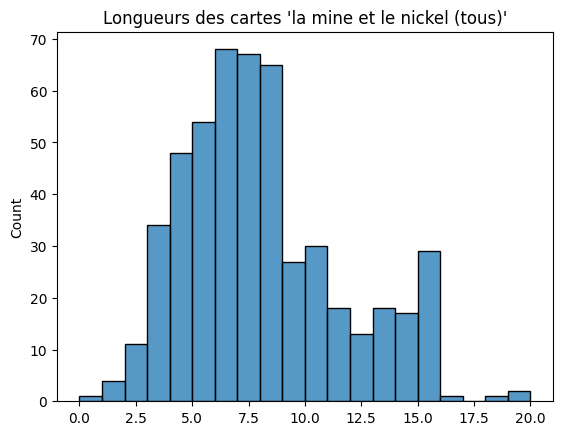

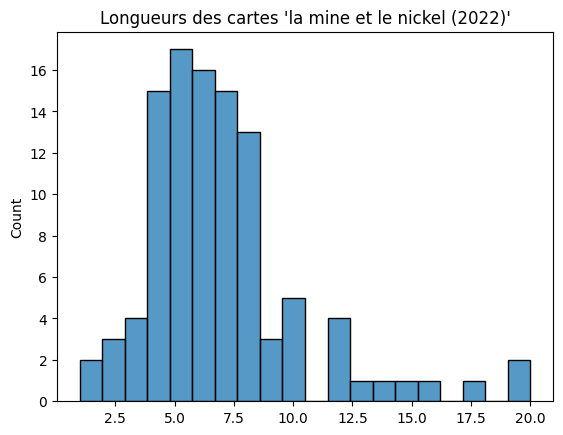

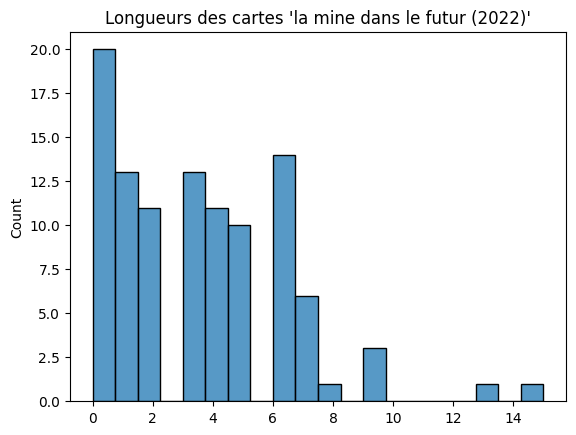

In [8]:
def get_n_words(dic, n: int):
    """Mot de la position n"""
    return [vals[n] for vals in dic.values() if n < len(vals)]

for cg, lbl in zip(CGS, LABELS):
    sns.histplot([len(vals) for vals in cg.values()], bins=20).set(title=f"Longueurs des cartes '{lbl}'")
    plt.show()


## Mots énoncés les plus communs

On va segmenter les données en _populations_ (e.g., "moins de 26 ans", "mineur", etc.) selon les attributs et générer un tableau avec :

- en ligne tous les mots énoncés dans les cartes "la mine"
- en colonne, les populations, avec pour chacune :
  - le nombre de fois où le mot a été énoncé par les membres de cette population
  - le nombre de fois "théorique" où le mot serait annoncé si il y avait indépendance des énonciations entre les populations
  - le % de fois où un membre de la population a énoncé le mot
- pour chaque groupe, on calcule ensuite un test du $\chi^2$ pour évaluer l'écart à l'indépendance


In [12]:
THRESHOLD_MIN_ENONCIATIONS = 20
LABEL_TOTAL = "Nb. occ."
LABEL_POS_MED = "Pos. médiane"
LABEL_POS_MOY = "Pos. moyenne"
ALL_SYMB = "*"
CLEF_TOTAL = (ALL_SYMB, ALL_SYMB, LABEL_TOTAL)
CLEF_POS_MED = (ALL_SYMB, ALL_SYMB, LABEL_POS_MED)
CLEF_POS_MOY = (ALL_SYMB, ALL_SYMB, LABEL_POS_MOY)

def pos_to_df(words):
    """transformation en DF"""
    df = pd.DataFrame(index=list(words.keys()))
    df[CLEF_TOTAL] = [len(ps) for ps in words.values()]
    df[CLEF_POS_MED] = [round(100 * median(ps),2) for ps in words.values()]
    df[CLEF_POS_MED] = [round(100 * fmean(ps),2) for ps in words.values()]

    # filtrage au dessus du seuil et tri
    # df = df[df[CLEF_TOTAL] >= threshold]
    df.sort_values(CLEF_TOTAL, key=op.neg, inplace=True)
    return df


for pos, lbl in zip(POS,LABELS):
    display(lbl)
    df = pos_to_df(pos)
    display(df)
    df.to_excel(OUTPUT_FOLDER / f"frequence-importance-{lbl}-{TODAY}.xlsx")



'la mine et le nickel (tous)'

,Nb. occ.,Pos. médiane,Pos. moyenne
nickel,189,87.50,78.22
pollution,182,57.14,58.47
économie,116,65.15,64.05
camion,104,69.05,67.04
environnement,100,62.50,59.14
...,...,...,...
challenge écologique,1,14.29,14.29
mafia,1,28.57,28.57
modernisation,1,86.67,86.67
valeur culturelle,1,75.00,75.00


'la mine et le nickel (2022)'

,Nb. occ.,Pos. médiane,Pos. moyenne
camion,34,75.00,67.58
usine,29,62.50,64.01
pollution,25,57.14,62.24
montagne,25,66.67,64.56
terre,24,66.67,61.73
...,...,...,...
mal de dos,1,55.00,55.00
?,1,70.00,70.00
dynamite,1,80.00,80.00
bien payé,1,20.00,20.00


'la mine dans le futur (2022)'

,Nb. occ.,Pos. médiane,Pos. moyenne
pollution,10,55.00,60.53
plus de montagne,9,66.67,64.44
je ne sais pas,8,100.00,93.75
plus de nickel,8,73.33,68.33
métal,5,76.92,60.38
...,...,...,...
moins d'espèces animales,1,50.00,50.00
moins de nickel dans le sol,1,33.33,33.33
plus de mine dans le monde,1,16.67,16.67
soleil,1,50.00,50.00


## Tableau de comparaison des mots énoncés par profil du répondant

**NB** Ici un gros point méthodologique : on va faire un test d'indépendance statistique $\chi^2$ sur les mots énoncés les plus fréquents afin de déterminer si leurs énonciations sont indépendantes ou pas des profils des répondants.

D'abord le gros code.

In [9]:
def add_population(df_population, df, cols, filtres, name):
    """Ajout de colonnes au df de synthèse des profils sur une population segmentée"""
    observed = []
    expected = []
    chi2 = stats.chi2(len(filtres) - 1)
    for filtre, val in filtres:
        # cg = get_cogmaps(df_mine[filtre], cols_mine)
        cg = get_cogmaps(df[filtre], cols)
        c = Counter(w for l in cg.values() for w in l)
        # print(f"Ajout de la colonne '{name}, {val}', {len(cg)} répondants, {c.total()} énonciations")

        key = (name, val, "Nb.")
        df_population[key] = pd.Series(c)
        df_population[key].fillna(0, inplace=True)
        df_population[key] = df_population[key].astype(int)

        # ici en % ** des répondants**
        df_population[(name, val, "Nb. th.")] = round(df_population[CLEF_TOTAL] * len(cg) / len(df), 2)
        exp = df_population[CLEF_TOTAL].to_numpy() * len(cg) / len(df)

        observed.append(df_population[key].to_numpy().reshape(-1, 1))
        expected.append(exp.reshape(-1, 1))

    obs, exp = np.concatenate(observed, axis=1), np.concatenate(expected, axis=1)
    chis = np.sum((obs - exp) ** 2 / exp, axis=1)
    p_vals = chi2.sf(chis)
    df_population[(name, "Chi²", "Significatif")] = [pretty_pvals(v) for v in p_vals]


def generate_all_filters(col):
    values = df_resp[col].dropna().unique()
    return [(df_resp[col] == value, value) for value in values]


def prepare_chi_analysis(positions, cg, cols, title):
    df = pos_to_df(positions)

    moins_de_26_ans = df_resp["Question 12"] < 26
    add_population(df, cg, cols, [(moins_de_26_ans, "Oui"), (~moins_de_26_ans, "Non")], "Age < 26")
    add_population(df, cg, cols, generate_all_filters("Question 13"), "Genre")
    add_population(df, cg, cols, generate_all_filters("Question 1"), "Travaille dans la mine")
    add_population(df, cg, cols, generate_all_filters("Question 4"), "Famille dans la mine")
    add_population(df, cg, cols, generate_all_filters("Question 5"), "Toujours vécu en NC")
    add_population(df, cg, cols, generate_all_filters("Question 8.2"), "Commune minière")

    # nettoyage final
    df.fillna(0.0, inplace=True)
    df.columns = pd.MultiIndex.from_tuples(df.columns)
    df.columns.set_names(["Variable", "Catégorie", "Statistique"], inplace=True)

    df.to_excel(OUTPUT_FOLDER / f"analyse_par_population-{title}-{TODAY}.xlsx")

    return df


for positions, cg, cols, lbl in zip(POS, [df_mine, df_mine, df_futur], [cols_mine, cols_mine, cols_futur], LABELS):
    df_distribution = prepare_chi_analysis(positions, cg, cols, lbl)
    print(f"Analyse des mots par population pour la carte '{lbl.capitalize()}'")
    display(df_distribution)


Analyse des mots par population pour la carte 'La mine et le nickel (tous)'


Variable                      *                           Age < 26          \
Catégorie                     *                                Oui           
Statistique            Nb. occ. Pos. médiane Pos. moyenne      Nb. Nb. th.   
nickel                      189        87.50        78.22      151  135.43   
pollution                   182        57.14        58.47      118  130.41   
économie                    116        65.15        64.05       80   83.12   
camion                      104        69.05        67.04       92   74.52   
environnement               100        62.50        59.14       60   71.65   
...                         ...          ...          ...      ...     ...   
challenge écologique          1        14.29        14.29        0    0.72   
mafia                         1        28.57        28.57        0    0.72   
modernisation                 1        86.67        86.67        0    0.72   
valeur culturelle             1        75.00        75.00        1    0.72   
pollution de la nature        1        12.50        12.50        1    0.72   

Variable                                        Genre          ...  \
Catégorie              Non                 Chi² Homme          ...   
Statistique            Nb. Nb. th. Significatif   Nb. Nb. th.  ...   
nickel                  38   53.57            *    81   84.08  ...   
pollution               64   51.59            *    91   80.97  ...   
économie                36   32.88                 52   51.61  ...   
camion                  12   29.48          ***    41   46.27  ...   
environnement           40   28.35           **    47   44.49  ...   
...                     ..     ...          ...   ...     ...  ...   
challenge écologique     1    0.28                  0    0.44  ...   
mafia                    1    0.28                  1    0.44  ...   
modernisation            1    0.28                  0    0.44  ...   
valeur culturelle        0    0.28                  0    0.44  ...   
pollution de la nature   0    0.28                  1    0.44  ...   

Variable               Toujours vécu en NC                       \
Catégorie                              Non                 Chi²   
Statistique                            Nb. Nb. th. Significatif   
nickel                                  40   39.06                
pollution                               41   37.62                
économie                                26   23.98                
camion                                   6   21.50          ***   
environnement                           25   20.67                
...                                    ...     ...          ...   
challenge écologique                     1    0.21                
mafia                                    1    0.21                
modernisation                            0    0.21                
valeur culturelle                        0    0.21                
pollution de la nature                   0    0.21                

Variable               Commune minière                                    \
Catégorie                      Minière         Mixte         Non minière   
Statistique                        Nb. Nb. th.   Nb. Nb. th.         Nb.   
nickel                              53   55.06    67   43.16          68   
pollution                           61   53.02    41   41.56          80   
économie                            39   33.80    42   26.49          35   
camion                              22   30.30    21   23.75          61   
environnement                       30   29.13    34   22.83          36   
...                                ...     ...   ...     ...         ...   
challenge écologique                 1    0.29     0    0.23           0   
mafia                                1    0.29     0    0.23           0   
modernisation                        1    0.29     0    0.23           0   
valeur culturelle                    0    0.29     1    0.23           0   

Analyse des mots par population pour la carte 'La mine et le nickel (2022)'


Variable                      *                           Age < 26          \
Catégorie                     *                                Oui           
Statistique            Nb. occ. Pos. médiane Pos. moyenne      Nb. Nb. th.   
camion                       34        75.00        67.58       92   24.36   
usine                        29        62.50        64.01       83   20.78   
pollution                    25        57.14        62.24      118   17.91   
montagne                     25        66.67        64.56       61   17.91   
terre                        24        66.67        61.73       60   17.20   
...                         ...          ...          ...      ...     ...   
mal de dos                    1        55.00        55.00        1    0.72   
?                             1        70.00        70.00        1    0.72   
dynamite                      1        80.00        80.00        3    0.72   
bien payé                     1        20.00        20.00        1    0.72   
pollution de la nature        1        12.50        12.50        1    0.72   

Variable                                        Genre          ...  \
Catégorie              Non                 Chi² Homme          ...   
Statistique            Nb. Nb. th. Significatif   Nb. Nb. th.  ...   
camion                  12    9.64         ****    41   15.13  ...   
usine                    6    8.22         ****    33   12.90  ...   
pollution               64    7.09         ****    91   11.12  ...   
montagne                16    7.09         ****    27   11.12  ...   
terre                   13    6.80         ****    34   10.68  ...   
...                     ..     ...          ...   ...     ...  ...   
mal de dos               0    0.28                  1    0.44  ...   
?                        0    0.28                  1    0.44  ...   
dynamite                 0    0.28           **     2    0.44  ...   
bien payé                0    0.28                  1    0.44  ...   
pollution de la nature   0    0.28                  1    0.44  ...   

Variable               Toujours vécu en NC                       \
Catégorie                              Non                 Chi²   
Statistique                            Nb. Nb. th. Significatif   
camion                                   6    7.03         ****   
usine                                   15    5.99         ****   
pollution                               41    5.17         ****   
montagne                                 8    5.17         ****   
terre                                   10    4.96         ****   
...                                    ...     ...          ...   
mal de dos                               0    0.21                
?                                        0    0.21                
dynamite                                 0    0.21            *   
bien payé                                0    0.21                
pollution de la nature                   0    0.21                

Variable               Commune minière                                    \
Catégorie                      Minière         Mixte         Non minière   
Statistique                        Nb. Nb. th.   Nb. Nb. th.         Nb.   
camion                              22    9.91    21    7.76          61   
usine                               18    8.45    21    6.62          50   
pollution                           61    7.28    41    5.71          80   
montagne                            19    7.28    14    5.71          44   
terre                               13    6.99     9    5.48          51   
...                                ...     ...   ...     ...         ...   
mal de dos                           0    0.29     0    0.23           1   
?                                    0    0.29     0    0.23           1   
dynamite                             2    0.29     0    0.23           1   
bien payé                            0    0.29     0    0.23           1   

Analyse des mots par population pour la carte 'La mine dans le futur (2022)'


Variable                                    *                            \
Catégorie                                   *                             
Statistique                          Nb. occ. Pos. médiane Pos. moyenne   
pollution                                  10        55.00        60.53   
plus de montagne                            9        66.67        64.44   
je ne sais pas                              8       100.00        93.75   
plus de nickel                              8        73.33        68.33   
métal                                       5        76.92        60.38   
...                                       ...          ...          ...   
moins d'espèces animales                    1        50.00        50.00   
moins de nickel dans le sol                 1        33.33        33.33   
plus de mine dans le monde                  1        16.67        16.67   
soleil                                      1        50.00        50.00   
engin plus gros et plus sophistiqués        1        50.00        50.00   

Variable                             Age < 26                      \
Catégorie                                 Oui         Non           
Statistique                               Nb. Nb. th. Nb. Nb. th.   
pollution                                  89    7.17  33    2.83   
plus de montagne                            8    6.45   1    2.55   
je ne sais pas                              0    5.73   8    2.27   
plus de nickel                              8    5.73   0    2.27   
métal                                       7    3.58   0    1.42   
...                                       ...     ...  ..     ...   
moins d'espèces animales                    1    0.72   0    0.28   
moins de nickel dans le sol                 1    0.72   0    0.28   
plus de mine dans le monde                  1    0.72   0    0.28   
soleil                                      1    0.72   0    0.28   
engin plus gros et plus sophistiqués        1    0.72   0    0.28   

Variable                                          Genre          ...  \
Catégorie                                    Chi² Homme          ...   
Statistique                          Significatif   Nb. Nb. th.  ...   
pollution                                    ****    50    4.45  ...   
plus de montagne                                      7    4.00  ...   
je ne sais pas                               ****     4    3.56  ...   
plus de nickel                                        5    3.56  ...   
métal                                           *     5    2.22  ...   
...                                           ...   ...     ...  ...   
moins d'espèces animales                              0    0.44  ...   
moins de nickel dans le sol                           0    0.44  ...   
plus de mine dans le monde                            0    0.44  ...   
soleil                                                0    0.44  ...   
engin plus gros et plus sophistiqués                  1    0.44  ...   

Variable                             Toujours vécu en NC                       \
Catégorie                                            Non                 Chi²   
Statistique                                          Nb. Nb. th. Significatif   
pollution                                             29    2.07         ****   
plus de montagne                                       0    1.86                
je ne sais pas                                         0    1.65                
plus de nickel                                         0    1.65                
métal                                                  0    1.03                
...                                                  ...     ...          ...   
moins d'espèces animales                               1    0.21                
moins de nickel dans le sol                            1    0.21                
plus de mine dans le monde                             1    0.21                
s

## Analyse des correspondances des mots énoncés

On commence par faire l'analyse sur les mots énoncés, ensuite, on fera avec les concepts du thésaurus.


In [10]:
# nombre de fois ou un mot dois être cité toute classe confondues
ROW_THRESHOLD = 3
# nombre de mots cités pour la valeur de la catégorie
COL_THRESHOLD = 30

def gen_ca_dataset(cartes : dict[str, list[str]], attribut:str, min_row = ROW_THRESHOLD, min_col = COL_THRESHOLD):
    """Génère un DataFrame au format requis pour une analyse des correspondances. l'attribut est une des questions"""
    
    # pour chaque mot énoncé, le nombre d'occurrences
    all_words = Counter(w for l in cartes.values() for w in l)

    # toutes les valeurs de la catégorie
    cats = df_complete[attribut].dropna().unique()
    # on génère les filtres : pour chaque valeur de la catégorie, les cartes considérées
    cats_filters = {value: (df_resp[attribut] == value) for value in cats}

    # on prépare le DF résultat avec comme index tous les mots cotés
    df = pd.DataFrame(index=all_words)

    for group in sorted(cats_filters.keys()):
        ids = cats_filters[group].index[cats_filters[group]].to_list()
        cogs = Counter(mot for num, mots in cartes.items() if num in ids for mot in mots)
        # print(f"Groupe {group} :  {len(ids)} individus, {len(cogs)} mots énoncés")
        df[group] = pd.Series(cogs)

    df = df.fillna(0).astype(int)
    df.columns.name = questions_labels.get(attribut, attribut)
    df.index.name = "Mot énoncé"

    # on filtre les mots énoncés au moins 20x pour les classes qui énoncent au moins 100 mots
    row_margin = df.sum(axis=1)
    col_margin = df.sum(axis=0)
    
    return df.loc[row_margin > min_row, col_margin > min_col]


GAD,10-19 ans,20-29 ans,30-39 ans,40-49 ans,50-59 ans,60-69 ans
Mot énoncé,,,,,,
pollution,69,59,13,10,20,8
travail,39,37,6,6,8,4
richesse,24,29,5,4,6,3
destruction,17,20,6,3,7,5
argent,30,18,8,5,11,3
nickel,82,77,8,5,13,1
production,5,1,0,1,3,0
nature,9,5,3,1,8,1
extraction,12,6,1,1,1,1


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.111469,254.372738,54.530650,54.530650
2,0.034384,78.465038,16.820787,71.351436
3,0.027888,63.639419,13.642574,84.994010
4,0.017581,40.120915,8.600841,93.594851
5,0.013093,29.878521,6.405149,100.000000


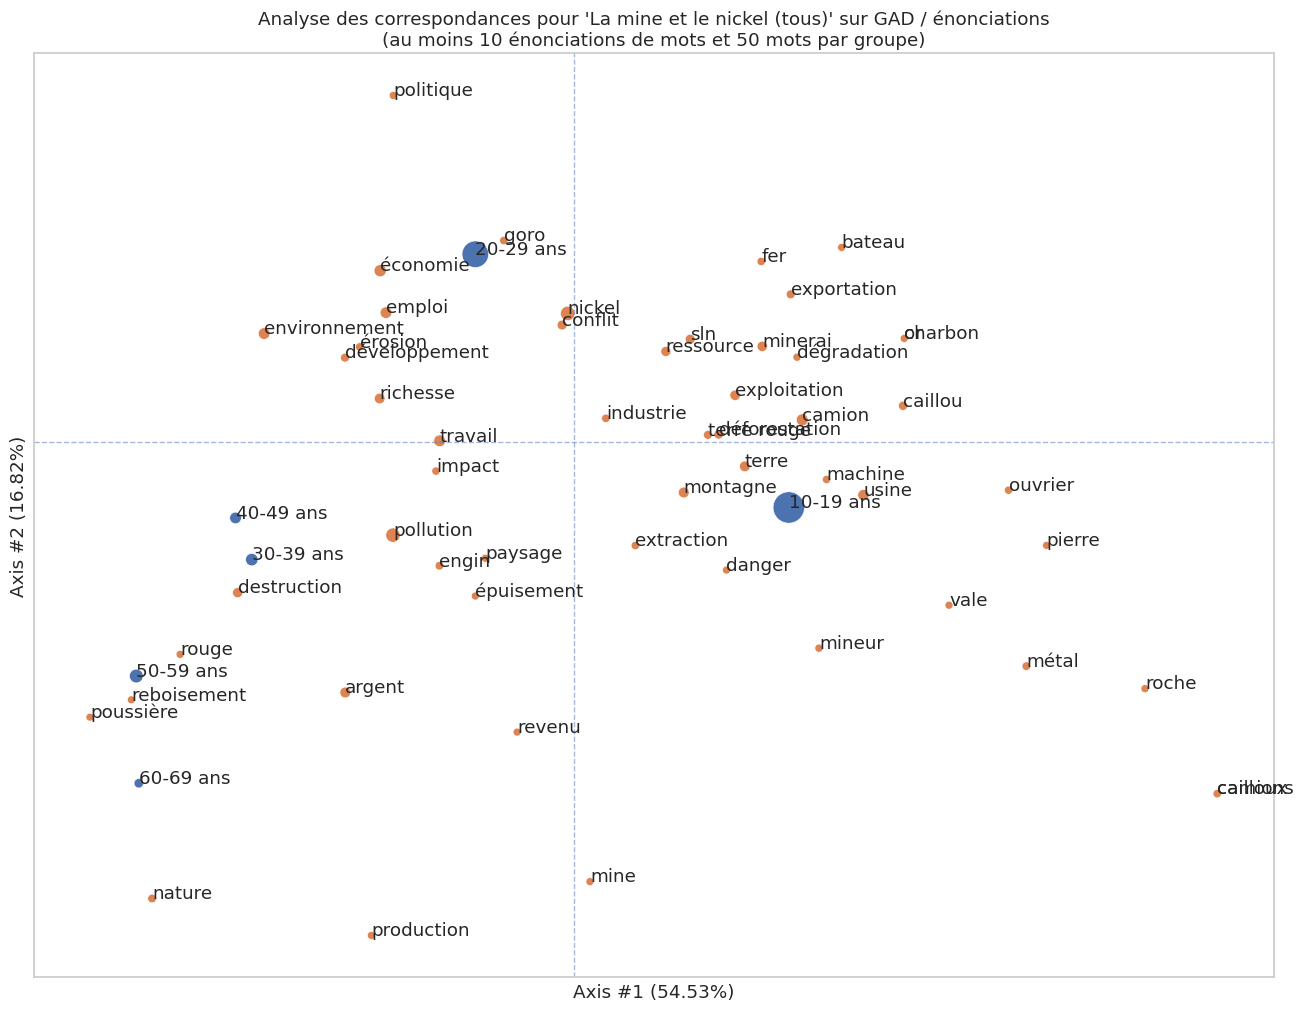

Commune de résidence.,Bourail,Dumbéa,Hienghène,Koné,Lifou,Mont-Dore,Nouméa,Païta,Thio,Touho,Yaté
Mot énoncé,,,,,,,,,,,
pollution,3,24,26,4,3,27,36,16,11,0,16
travail,0,18,10,2,5,8,22,11,6,1,9
richesse,0,14,7,0,0,9,22,9,3,0,2
destruction,2,10,9,2,1,11,10,3,2,1,1
argent,1,8,16,2,1,10,11,5,4,1,9
nickel,5,25,10,4,5,44,63,11,2,2,1
production,0,1,0,0,0,3,4,1,2,0,0
nature,1,1,8,0,1,3,2,5,1,0,3
extraction,2,3,0,1,0,7,6,0,1,0,1


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.215146,449.009977,49.134119,49.134119
2,0.075858,158.316033,17.324156,66.458275
3,0.029866,62.330483,6.820680,73.278954
4,0.027125,56.609707,6.194669,79.473623
5,0.023133,48.278161,5.282967,84.756590
6,0.018194,37.971540,4.155137,88.911728
7,0.015016,31.337732,3.429215,92.340943
8,0.013037,27.207665,2.977272,95.318215
9,0.010404,21.713328,2.376039,97.694254


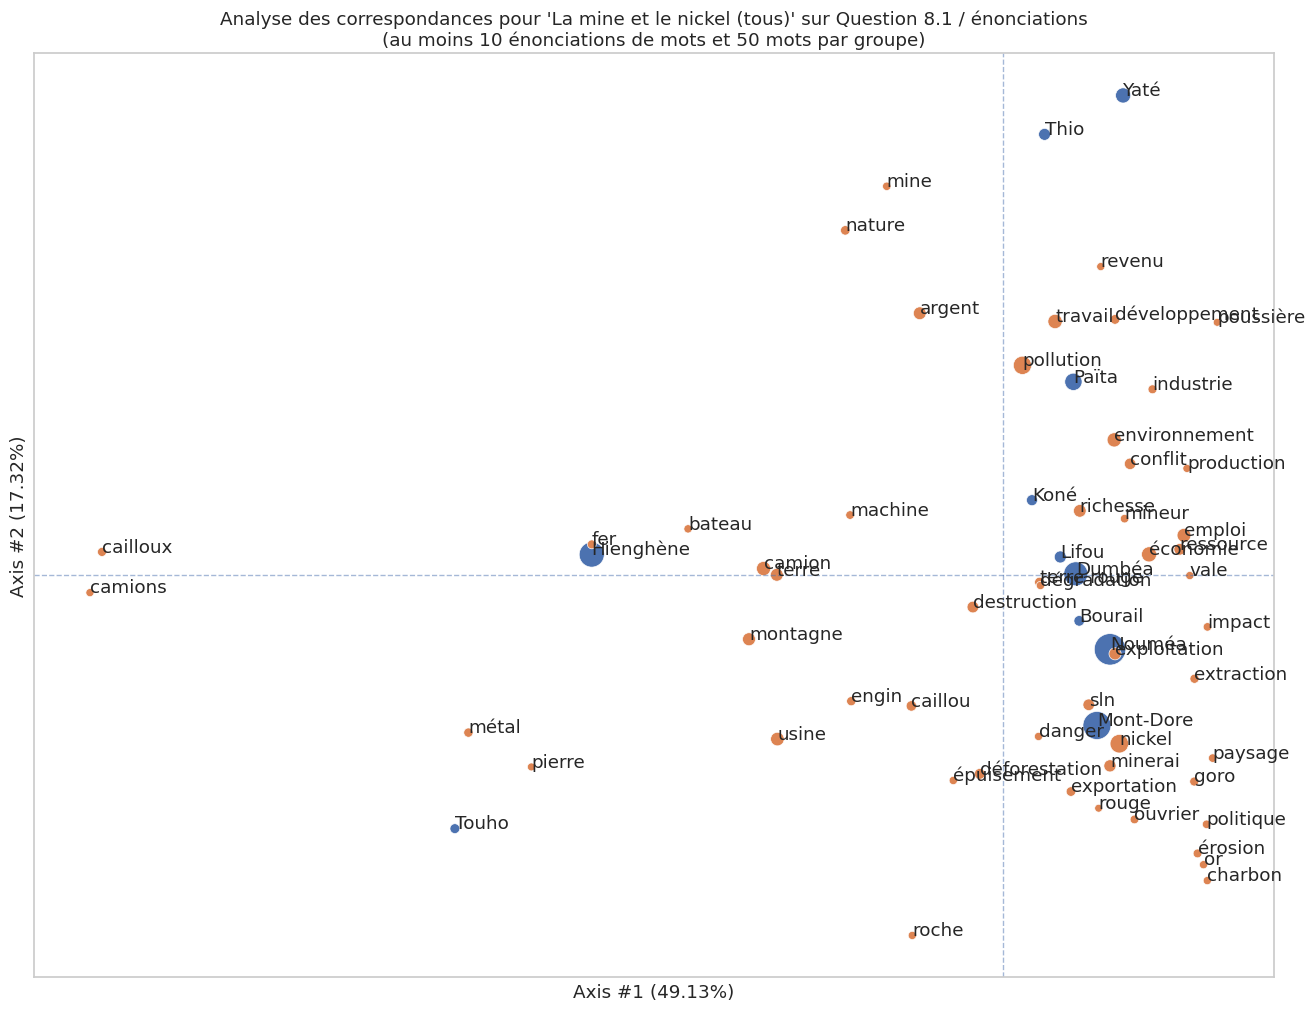

GAD,10-19 ans,20-29 ans,30-39 ans,50-59 ans,60-69 ans
Mot énoncé,,,,,
environnement,1,2,1,1,0
richesse,4,1,0,0,0
pollution,15,2,3,1,2
nature,1,1,1,3,1
économie,2,1,1,0,0
destruction,1,2,2,3,3
terre,19,2,1,1,1
travail,6,1,2,0,2
argent,9,3,2,3,1


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.449545,158.239761,72.107899,72.107899
2,0.084388,29.704596,13.536016,85.643915
3,0.065427,23.030220,10.494586,96.138501
4,0.024074,8.474005,3.861499,100.000000


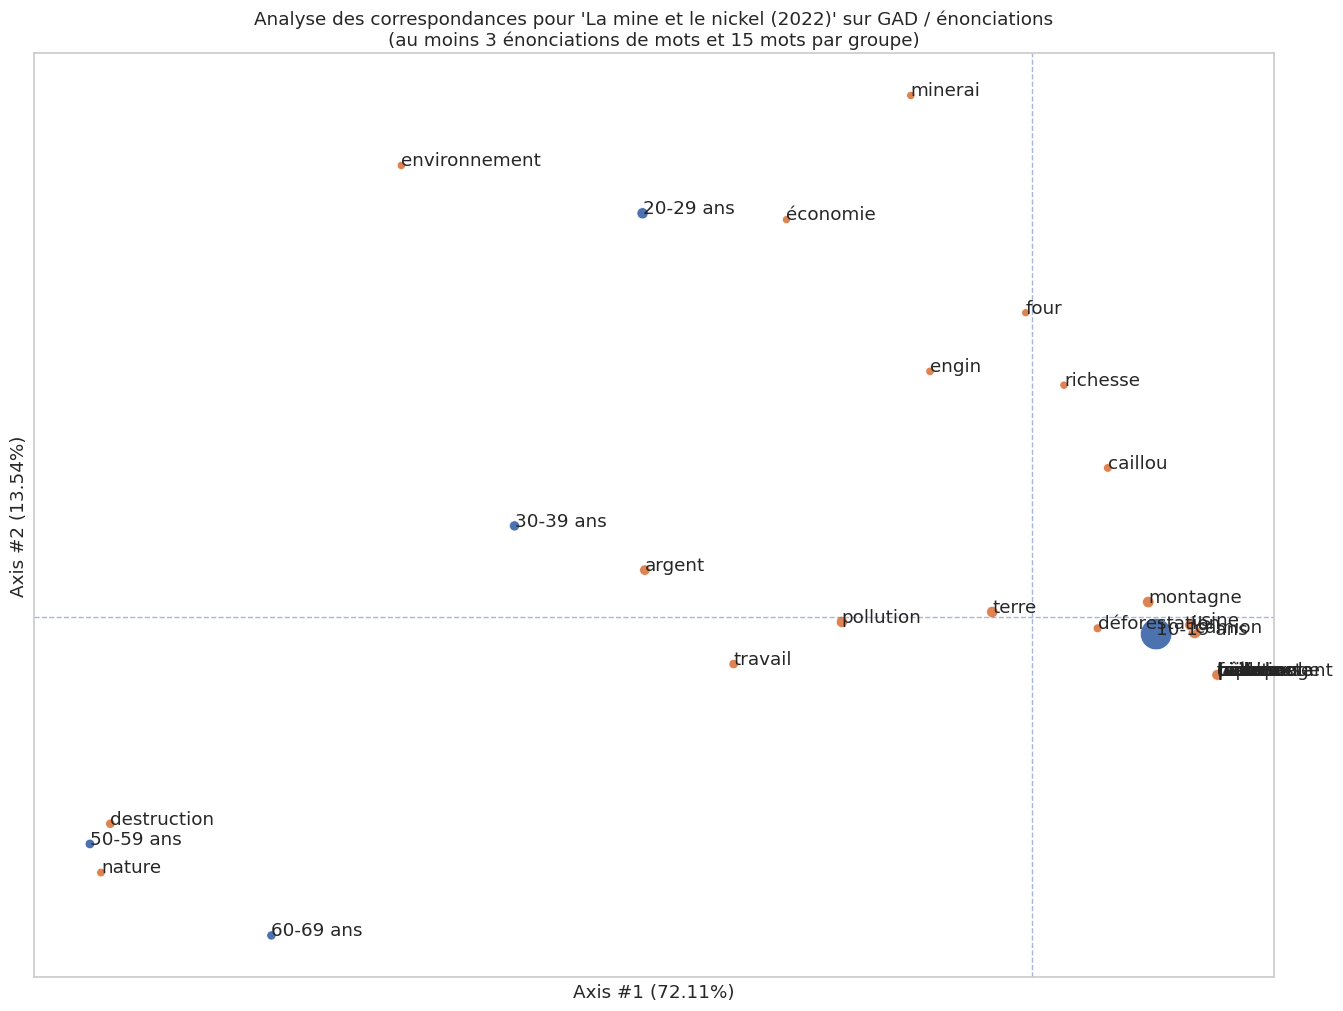

Commune de résidence.,Hienghène,Touho
Mot énoncé,,
environnement,5,0
richesse,6,0
pollution,25,0
nature,8,0
économie,4,0
destruction,9,1
terre,21,3
travail,9,1
argent,16,1


Impossible de représenter : pas assez de données pour la mine et le nickel (2022) de dimension 34x2


GAD,10-19 ans,30-39 ans,50-59 ans
Mot énoncé,,,
je ne sais pas,0,1,1
plus de montagne,8,1,0
pollution,10,0,0
montagne,4,0,0
métal,5,0,0
plus de nickel,8,0,0
plus de travailleur,4,0,0
moins de nickel,4,0,0
camion,5,0,0


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.756435,38.578206,96.111794,96.111794
2,0.030602,1.560683,3.888206,100.000000


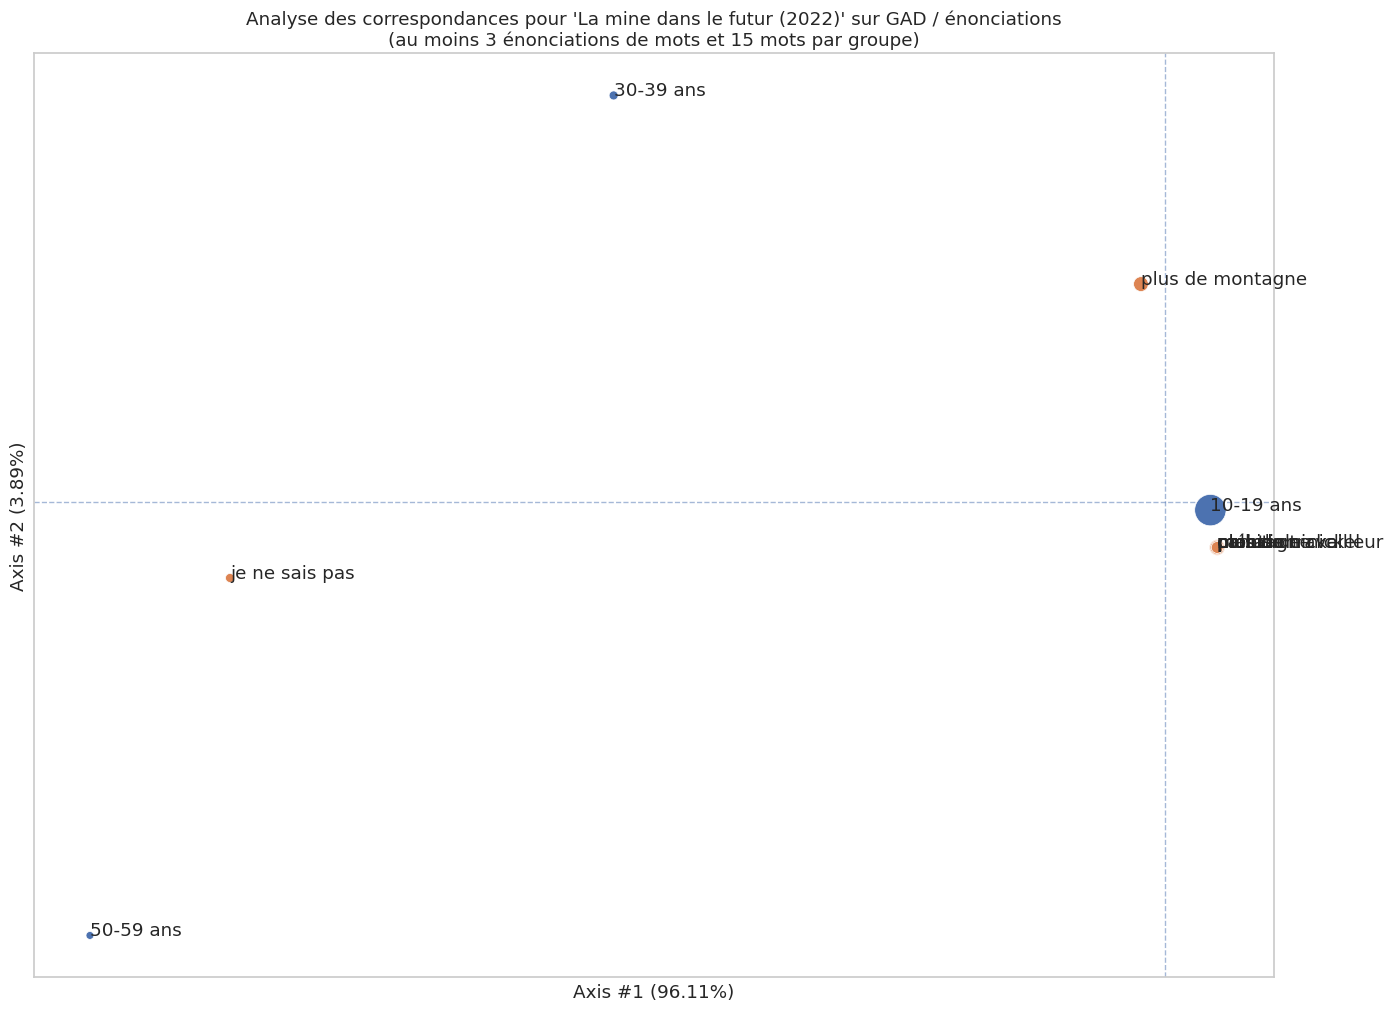

Commune de résidence.,Hienghène,Touho
Mot énoncé,,
je ne sais pas,8,0
plus de montagne,8,1
pollution,8,2
montagne,3,1
métal,5,0
plus de nickel,7,1
plus de travailleur,4,0
moins de nickel,4,0
camion,4,1


Impossible de représenter : pas assez de données pour la mine dans le futur (2022) de dimension 9x2


In [11]:
sns.set_theme(style="whitegrid", font_scale=1.10, rc={"figure.figsize": (16, 12)})
ca = CA(42)

MIN_ROWS = (10, 3, 3)
MIN_COLS = (50, 15, 15)


# for cg, lbl, row, col in zip(CGS, LABELS, MIN_ROWS, MIN_COLS):
#     df = gen_ca_dataset(cg, "GAD", row, col)
#     display(df)


for cg, lbl, row, col in zip(CGS, LABELS, MIN_ROWS, MIN_COLS):
    for attribut in ["GAD", "Question 8.1"]:  # , 
        df_distribution = gen_ca_dataset(cg, attribut, row, col)
        display(df_distribution)
        if len(df_distribution.columns) <= 2 or len(df_distribution) <= 2:
            print(
                f"Impossible de représenter : pas assez de données pour {lbl} de dimension {len(df_distribution)}x{len(df_distribution.columns)}"
            )
            continue
        # display(ref.sort_index())
        ca.fit(df_distribution)
        display(ca.axes())
        ca.plot(coords=("principal", "principal"), legend=None).set(
            title=f"Analyse des correspondances pour '{lbl.capitalize()}' sur {attribut} / énonciations\n(au moins {row} énonciations de mots et {col} mots par groupe)"
        )
        plt.show()


## Distribution des énonciations

On commence par représenter le nombre de mots en fonction du nombre de citations sur une échelle logarithme-logarithme.
Clairement la majorité des mots (plus de 800) ne sont cités qu'une seule fois, mais on veut vérifier si la loi type Zipf est vérifiée sur le jeu de données.

In [12]:
def compute_histogramme_occurence(positions):
    """Transforme le dict des positions en un dict N.Occ. -> [mots]"""
    res = defaultdict(list)
    for word, positions in positions.items():
        res[len(positions)].append(word)
    return res

OCC_INV = [compute_histogramme_occurence(pos) for pos in POS]


In [13]:

def mot_enonces_plus_de_k_fois(positions, k):
    """renvoie le nb de mots au dessus du seuil et le nombre d'énonciations"""
    d = Counter({w: len(pos) for w, pos in positions.items() if len(pos) >= k})
    inv = compute_histogramme_occurence(positions)
    return len(d), d.total(), inv[k]


# mot_enonces_plus_de_k_fois(pos_mine_tous, 3)
# nb_max_enonciations = list(all_words_mine.most_common(1))[0][1]
# nb_max_enonciations

Distribution des énonciations pour 'La mine et le nickel (tous)'


,nb occurrences,total mots,% total mots,total énonciations,% total énonciations,nb mots,% nb mots,mots,derivée,derivée 2nd
0,1,902,100.0,3865,100.0,586,65.0,"[7 nains, ?, abus, achat, acheminement, activi...",NaN,NaN
1,2,316,35.0,3279,84.8,106,11.8,"[acide, agriculture, amélioration, ancêtre, ar...",-15.200000,NaN
2,3,210,23.3,3067,79.4,54,6.0,"[appauvrissement, barrage, blocage, chargement...",-5.400000,9.800000e+00
3,4,156,17.3,2905,75.2,33,3.7,"[biodiversité, boom, boue, dangereux, division...",-4.200000,1.200000e+00
4,5,123,13.6,2773,71.7,24,2.7,"[accident, bâteau, bénéfice, chaleur, dégât, d...",-3.500000,7.000000e-01
5,6,99,11.0,2653,68.6,12,1.3,"[aide, carrière, casque, changement, eau, géol...",-3.100000,4.000000e-01
6,7,87,9.6,2581,66.8,12,1.3,"[avenir, creuser, employé, four, fumée, matéri...",-1.800000,1.300000e+00
7,8,75,8.3,2497,64.6,11,1.2,"[arbre, commerce, doniambo, garniérite, gestio...",-2.200000,-4.000000e-01
8,9,64,7.1,2409,62.3,5,0.6,"[chantier, la terre, nouvelle-calédonie, pelle...",-2.300000,-1.000000e-01
9,10,59,6.5,2364,61.2,5,0.6,"[enjeu, sale, scories, transport, travailleur]",-1.100000,1.200000e+00


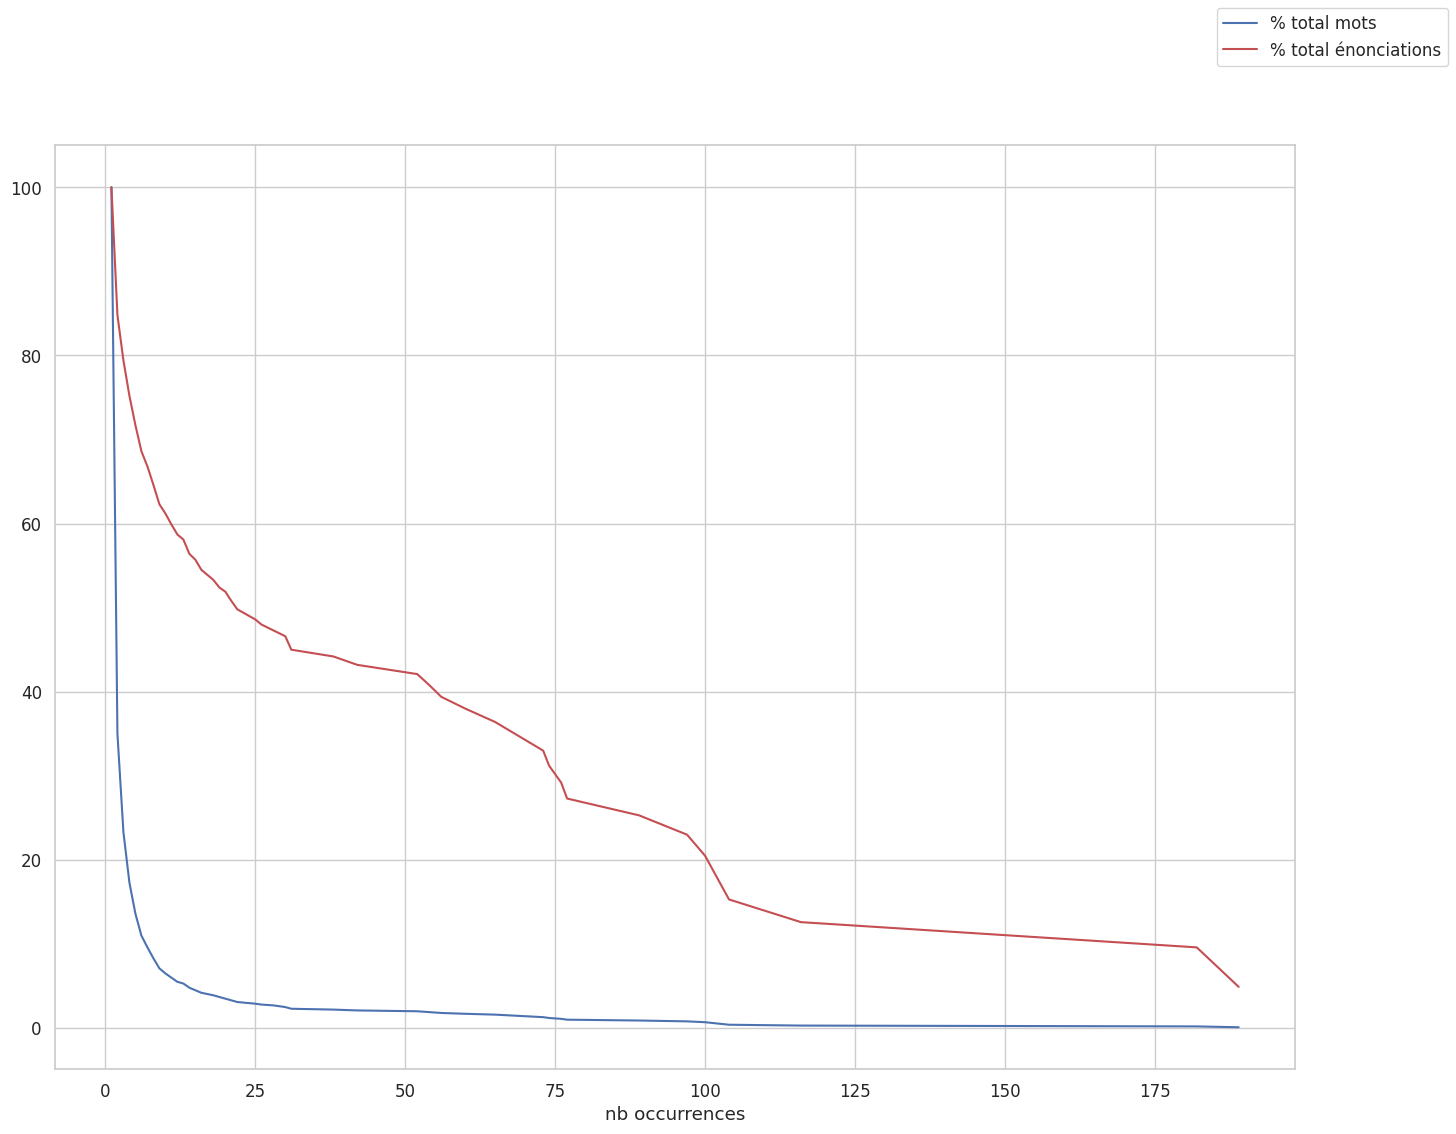

Distribution des énonciations pour 'La mine et le nickel (2022)'


,nb occurrences,total mots,% total mots,total énonciations,% total énonciations,nb mots,% nb mots,mots,derivée,derivée 2nd
0,1,335,100.0,711,100.0,260,77.6,"[?, achat, acide, affinage, agriculture, alarm...",NaN,NaN
1,2,75,22.4,451,63.4,30,9.0,"[chaleur, chargement, côte ouest, danger, dang...",-36.600,NaN
2,3,45,13.4,391,55.0,11,3.3,"[conflit, creuser, exploitation, koné, lave, r...",-8.400,28.200000
3,4,34,10.1,358,50.4,6,1.8,"[four, mine, tapis roulant, terre rouge, usine...",-4.600,3.800000
4,5,28,8.4,334,47.0,6,1.8,"[bâteau, machine, minerai, pelle, pelleteuse, ...",-3.400,1.200000
5,6,22,6.6,304,42.8,5,1.5,"[bateau, engin, environnement, pierre, richesse]",-4.200,-0.800000
6,7,17,5.1,274,38.5,1,0.3,[caillou],-4.300,-0.100000
7,8,16,4.8,267,37.6,2,0.6,"[déforestation, nature]",-0.900,3.400000
8,9,14,4.2,251,35.3,2,0.6,"[la terre, nickel]",-2.300,-1.400000
9,10,12,3.6,233,32.8,1,0.3,[fer],-2.500,-0.200000


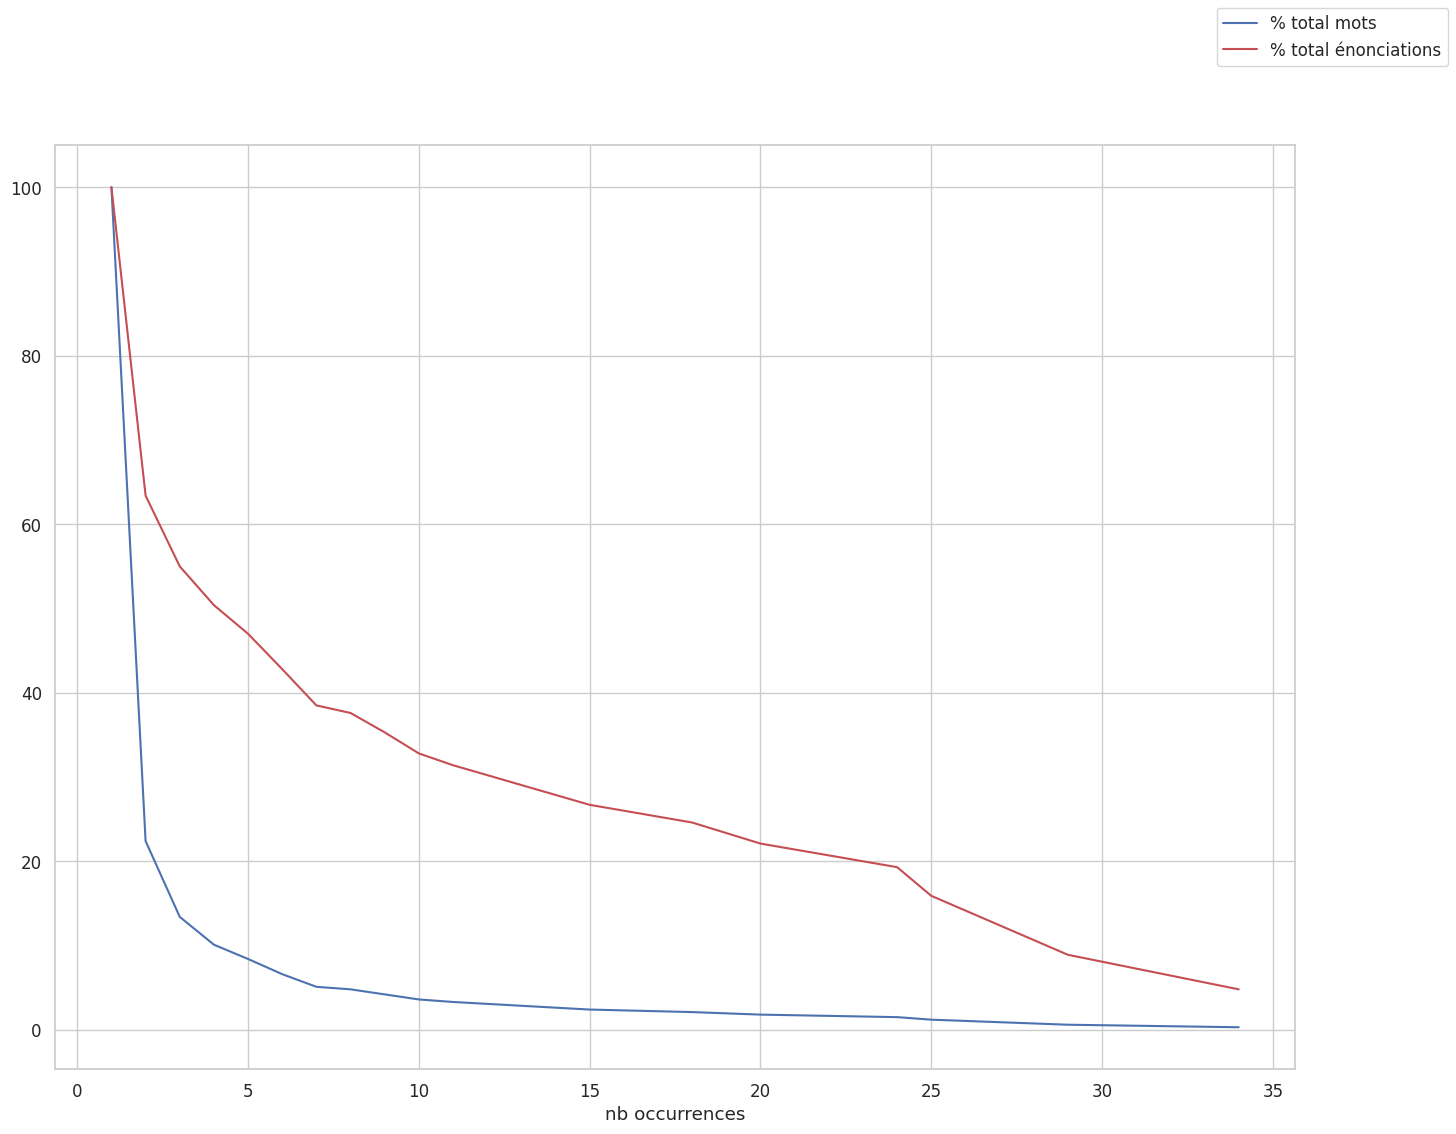

Distribution des énonciations pour 'La mine dans le futur (2022)'


,nb occurrences,total mots,% total mots,total énonciations,% total énonciations,nb mots,% nb mots,mots,derivée,derivée 2nd
0,1,262,100.0,357,100.0,217,82.8,"[3ème guerre mondiale, abîmer la terre et les ...",NaN,NaN
1,2,45,17.2,140,39.2,25,9.5,"[changement, danger, destruction du lagon, dis...",-60.800000,NaN
2,3,20,7.6,90,25.2,11,4.2,"[bâteau, cailloux, destruction, déforestation,...",-14.000000,46.800000
3,4,9,3.4,57,16.0,3,1.1,"[moins de nickel, montagne, plus de travailleur]",-9.200000,4.800000
4,5,6,2.3,45,12.6,2,0.8,"[camion, métal]",-3.400000,5.800000
5,8,4,1.5,35,9.8,2,0.8,"[je ne sais pas, plus de nickel]",-0.933333,0.822222
6,9,2,0.8,19,5.3,1,0.4,[plus de montagne],-4.500000,-3.566667
7,10,1,0.4,10,2.8,1,0.4,[pollution],-2.500000,2.000000


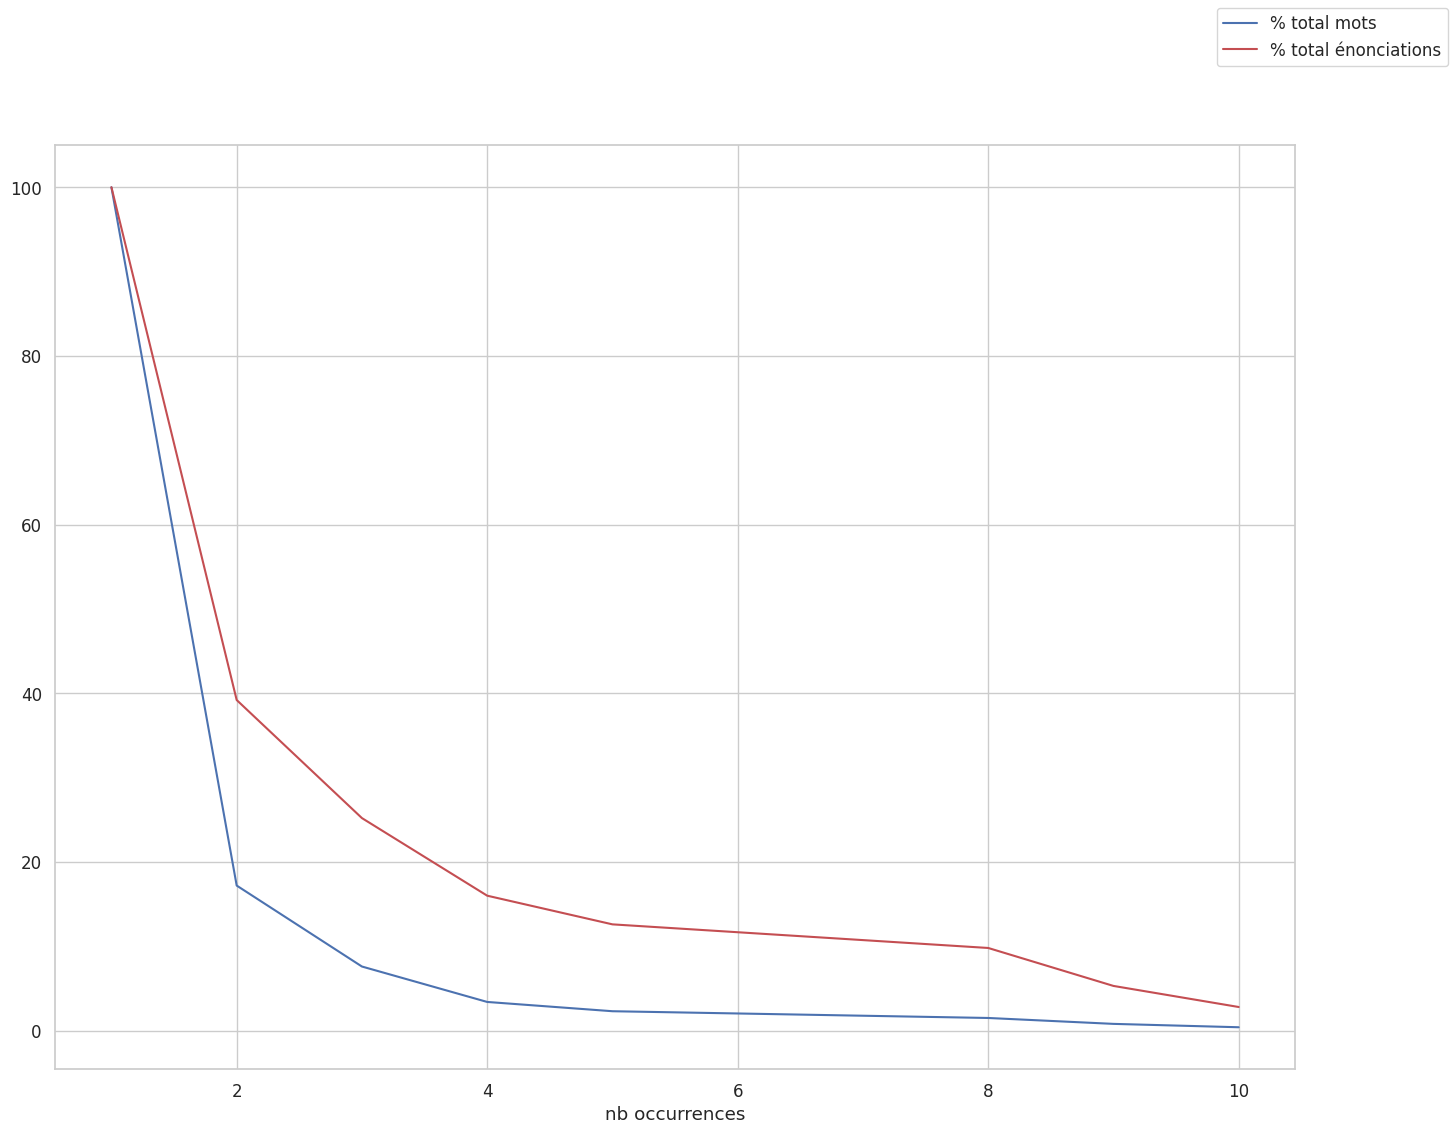

In [14]:
def generate_distribution(positions, label):
    nb_mots_total = len(positions)
    nb_enonciations_total = sum(len(ps) for ps in positions.values())

    res = []
    # for i in range(1, nb_max_enonciations+1):
    for i in sorted(set(len(ps) for ps in positions.values())):
        nb_mots, nb_enonciations, mots = mot_enonces_plus_de_k_fois(positions, i)
        row = (
            i,
            nb_mots,
            round(100 * nb_mots / nb_mots_total, 1),
            nb_enonciations,
            round(100 * nb_enonciations / nb_enonciations_total, 1),
            len(mots),
            round(100 * len(mots) / nb_mots_total, 1),
            sorted(mots)
            # ",".join(sorted(mots)),
        )
        res.append(row)

    columns = [
        "nb occurrences",
        "total mots",
        "% total mots",
        "total énonciations",
        "% total énonciations",
        "nb mots",
        "% nb mots",
        "mots",
    ]
    df = pd.DataFrame(res, columns=columns)  # .set_index("nb occurrences")

    df["derivée"] = df["% total énonciations"].rolling(window=2).apply(np.diff) / df["nb occurrences"].rolling(
        window=2
    ).apply(np.diff)
    df["derivée 2nd"] = df["derivée"].rolling(window=2).apply(np.diff) / df["nb occurrences"].rolling(window=2).apply(
        np.diff
    )


    df.name = f"Distribution des énonciations pour '{lbl.capitalize()}'"
    df.to_excel(OUTPUT_FOLDER / f"analyse_distribution_enonciations-{label}-{TODAY}.xlsx")
    return df


for pos, lbl in zip(POS, LABELS):
    df_distribution = generate_distribution(pos, lbl)
    print(df_distribution.name)
    display(df_distribution)
    ax = df_distribution.plot(x="nb occurrences", y="% total mots", legend=False)
    df_distribution.plot(x="nb occurrences", y="% total énonciations", ax=ax, legend=False, color="r")
    ax.figure.legend()
    plt.show(ax)


### Calcul des points de coupures

On calcule les nombres d'occurrences où la pente change de convexité avec le calcul de la dérivée seconde. 
On sélectionne _in fine_ les points de coupure à la main.

On donne un exemple sur les cartes complètes.

,nb occurrences,total mots,% total mots,total énonciations,% total énonciations,nb mots,% nb mots,mots,derivée,derivée 2nd
34,74,11,1.2,1204,31.2,1,0.1,[richesse],-1.8,-1.375
25,31,21,2.3,1740,45.0,1,0.1,[exportation],-1.6,-1.250
13,14,43,4.8,2181,56.4,2,0.2,"[mine, rouge]",-1.7,-1.100
36,77,9,1.0,1054,27.3,1,0.1,[montagne],-1.9,-0.900
19,21,30,3.3,1965,50.8,2,0.2,"[fer, goro]",-1.1,-0.600


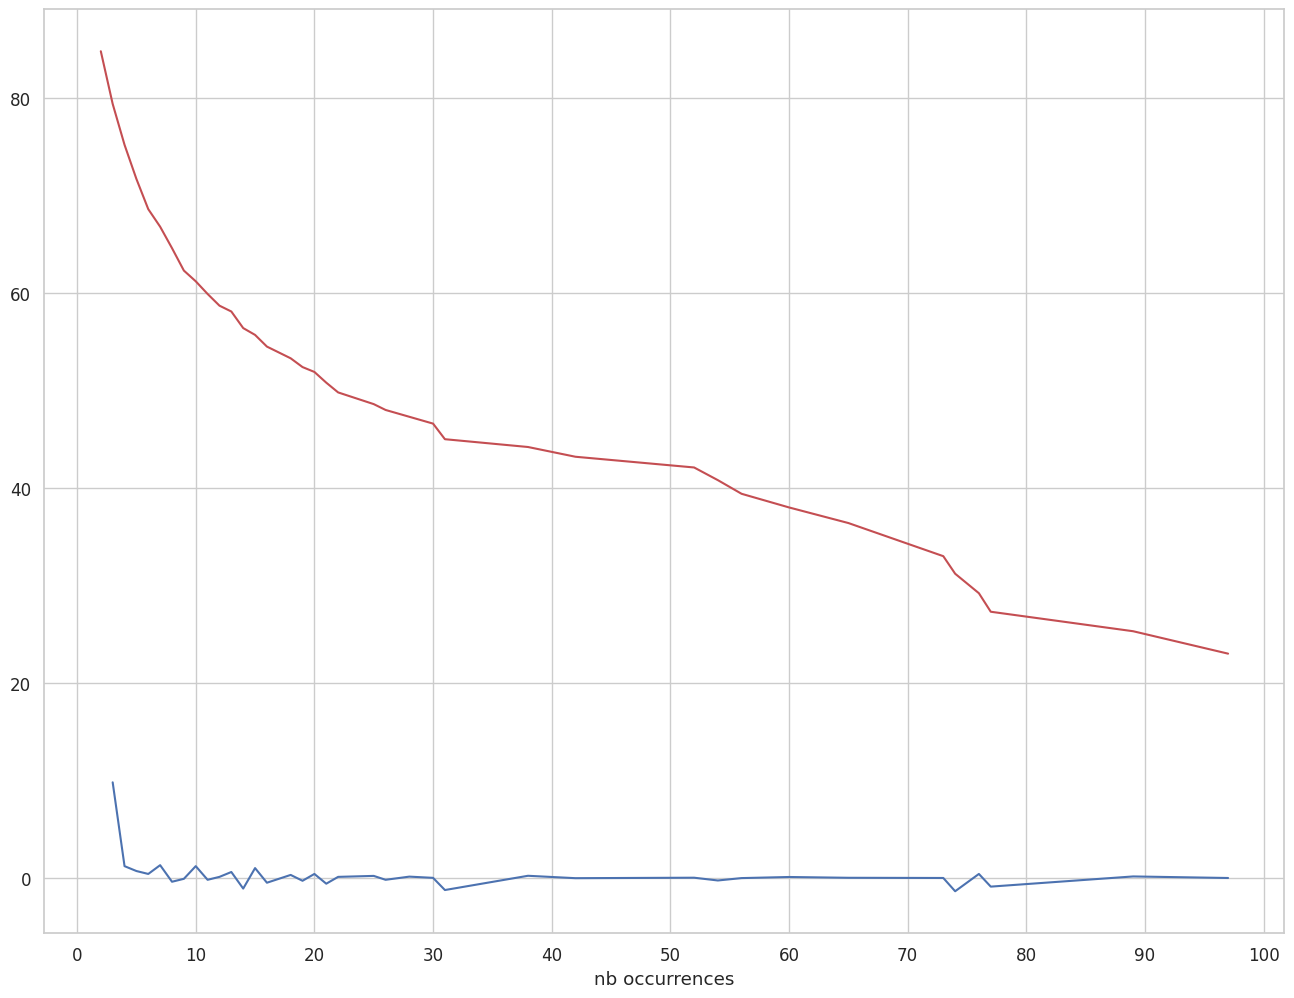

In [15]:
df_distribution = generate_distribution(POS[0], LABELS[0])
# on élimine les premières valeurs

df_distribution = df_distribution[(df_distribution["nb occurrences"] >= 2) & (df_distribution["nb occurrences"] < 100)]

ax = df_distribution.plot(
    x="nb occurrences", y="% total énonciations", legend=False, color="r", xticks=range(0, 200, 10)
)
# df.plot(x="nb occurrences", y="derivée", ax=ax, legend=False, color="g")
df_distribution.plot(x="nb occurrences", y="derivée 2nd", ax=ax, legend=False, color="b")


display(df_distribution.sort_values(by=["derivée 2nd"], ascending=True)[:5])


Ici, on coupe :

- pour `mine_tous` aux nombres d'occurrences _31_, _54_ et _77_ qui correspondent respectivement à 45%, 41% et 27% des énonciations totales.
- pour `mine_2022` à _6_ et _25_, pour 16% et 43%
- pour `futur_2022` nulle part

### Représentation radiale de la fréquence des mots



In [16]:
def generate_words_circles(positions, label, cuts):
    if cuts is None:
        cuts = [100, 50, 25, 10, 0]
    df_distribution = generate_distribution(positions, label)
    words = {}
    for cut_h, cut_l in pairwise(cuts):
        filter_cuts = df_distribution["% total énonciations"].between(cut_l, cut_h)
        words[(cut_l, cut_h)] = [w for ws in df_distribution[filter_cuts]["mots"] for w in ws]

    return words


cuts_mine_tous = [100, 45, 41, 27, 0]
cuts_mine_2022 = [100, 43, 16, 0]
cuts_futur_2022 = [100, 0]

CUTS = [cuts_mine_tous, cuts_mine_2022, cuts_futur_2022]

words_mine_tous = generate_words_circles(pos_mine_tous, "tous", cuts_mine_tous)
for th, ws in words_mine_tous.items():
    print(f"Nombre de mots qui représentent entre {th[0]}% et {th[1]}% des énonciations : {len(ws)}")
    if len(ws) < 50:
        print(f"\t{', '.join(ws)}")


Nombre de mots qui représentent entre 45% et 100% des énonciations : 882
Nombre de mots qui représentent entre 41% et 45% des énonciations : 4
	exportation, caillou, déforestation, conflit
Nombre de mots qui représentent entre 27% et 41% des énonciations : 9
	sln, ressource, destruction, exploitation, minerai, terre, richesse, argent, montagne
Nombre de mots qui représentent entre 0% et 27% des énonciations : 8
	usine, emploi, environnement, travail, camion, économie, pollution, nickel


Générations des nuages de mots : les mots sont dupliqués, leur taille est fonction du nombre d'occurrences

Nombre de mots qui représentent entre 0% et 27% des énonciations : 902, (10, 0, 0, 255)
Nombre de mots qui représentent entre 27% et 41% des énonciations : 902, (233, 0, 0, 255)
Nombre de mots qui représentent entre 41% et 45% des énonciations : 902, (255, 201, 0, 255)


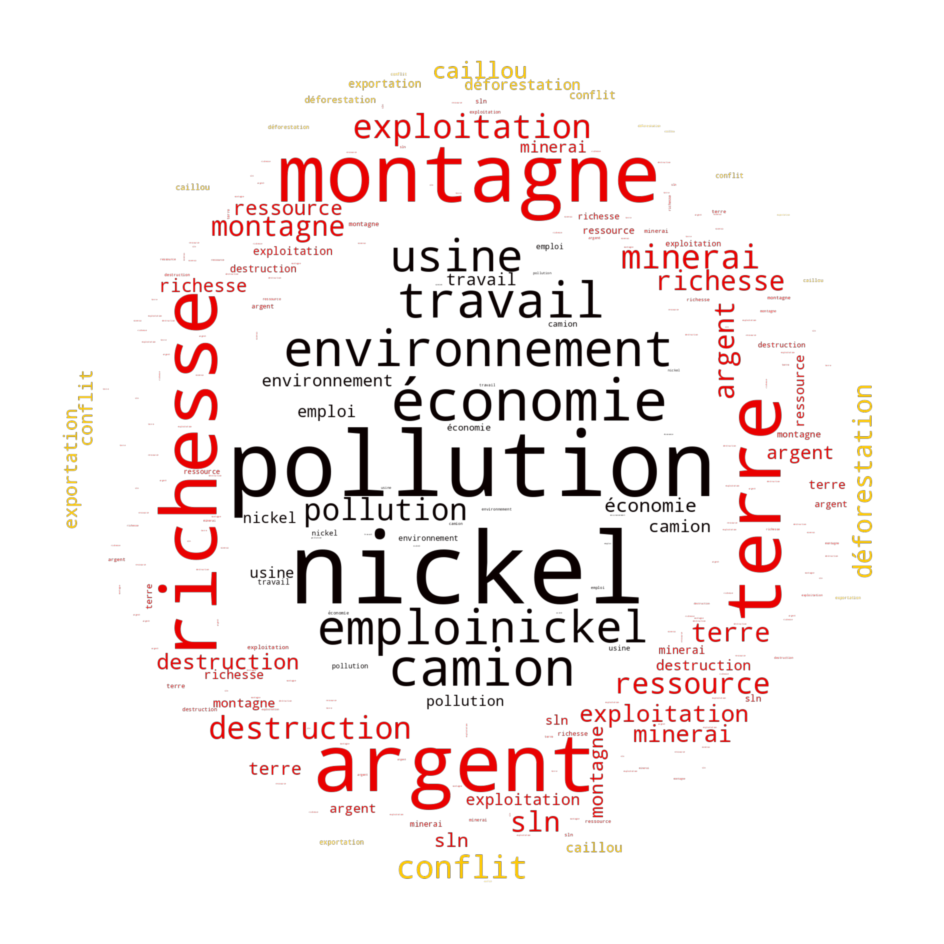

Nombre de mots qui représentent entre 0% et 27% des énonciations : 335, (10, 0, 0, 255)
Nombre de mots qui représentent entre 27% et 41% des énonciations : 335, (233, 0, 0, 255)
Nombre de mots qui représentent entre 41% et 45% des énonciations : 335, (255, 201, 0, 255)


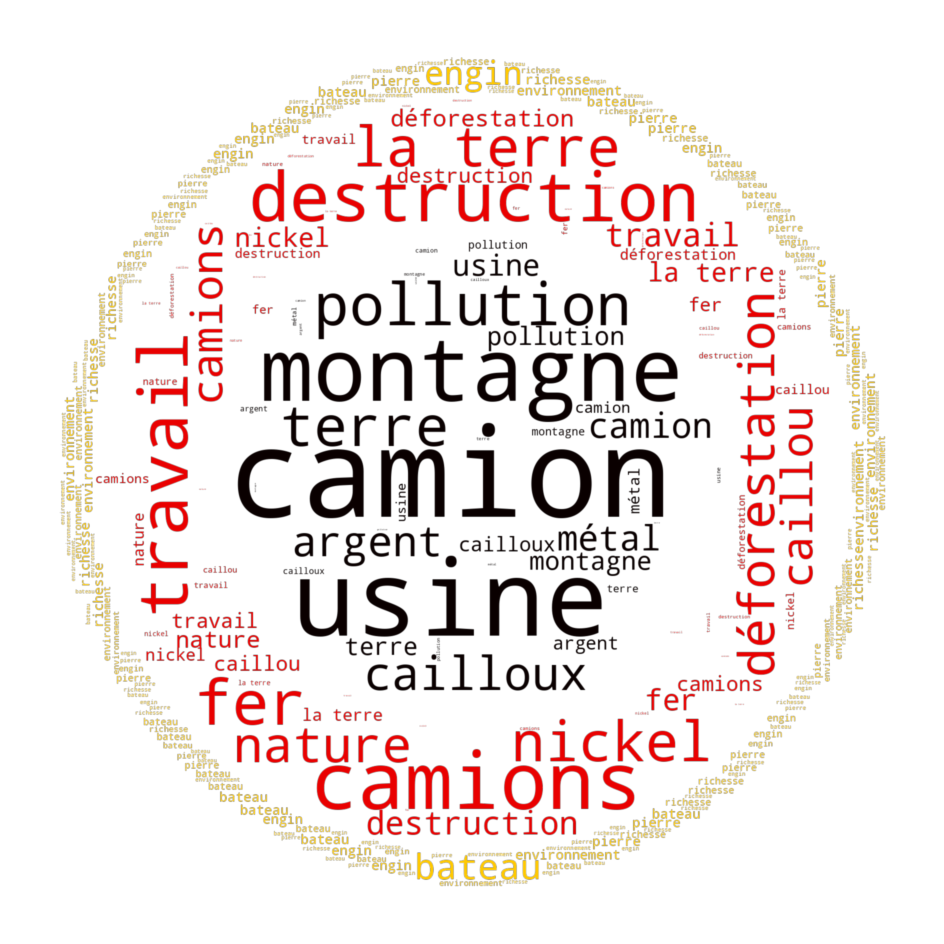

In [17]:
# https://medium.com/analytics-vidhya/delightful-figures-in-python-series-word-cloud-c515901798d2

SIZE = 1920
K = 1


def draw_wordcloud(positions, label, cuts, repeat=False):
    # tout sauf le premier, dans l'ordre inverse
    words_mine_tous = generate_words_circles(positions, label, cuts_mine_tous)

    words_lists = list(words_mine_tous.values())[-1:0:-1]
    sizes = list(pairwise(reversed(cuts_mine_tous)))[:-1:]

    x, y = np.ogrid[:SIZE, :SIZE]
    distance = ((x - SIZE // 2) ** 2 + (y - SIZE // 2) ** 2) ** 0.5
    deltas = [h - l for l, h in sizes]
    total_deltas = sum(deltas)

    plt.axis("off")

    for i, (bounds, words) in enumerate(zip(sizes, words_lists)):
        low, high = bounds
        delta = high - low

        # mask_outer = distance > (SIZE * K) * (high / (np.pi * total_deltas)) ** 0.5
        # mask_inner = distance < (SIZE * K) * (low / (np.pi * total_deltas)) ** 0.5
        mask_outer = distance > (SIZE * K) * (high / 100)
        mask_inner = distance < (SIZE * K) * (low / 100)
        mask = 255 * (mask_outer | mask_inner).astype(int)
        cmap = plt.get_cmap("hot")
        the_colour = cmap(i / len(sizes), bytes=True)
        print(
            f"Nombre de mots qui représentent entre {low}% et {high}% des énonciations : {len(positions)}, {the_colour}"
        )
        wc = WordCloud(
            background_color=None,
            mode="RGBA",
            color_func=lambda *args, **kwargs: the_colour,
            repeat=repeat,
            mask=mask,
            relative_scaling=1.0,
        )
        frequencies = {word: len(positions[word]) for word in words}
        wc.generate_from_frequencies(frequencies)
        # wc.generate(" ".join(positions))
        plt.imshow(wc, interpolation="gaussian")

    plt.show()


for p, l, c in zip(POS[:-1], LABELS, CUTS):
    draw_wordcloud(p, l, c, repeat=True)


## Calculs des listes d'Abric


On va séparer les mots selon deux dimensions :

- la fréquence : selon le nombre d'occurrences, en coupant sur un point de coupure
- l'importance : en évaluant la position médiane du mot lors des énonciations, en demandant qu'elle soit dans le 1er tier (66%)

In [18]:
def split_df(positions, cut_occurrences, cut_importance=66):
    df = pos_to_df(positions)
    filter_occ = df[CLEF_TOTAL] >= cut_occurrences
    filter_importance = df[CLEF_POS_MED] >= cut_importance
    return {
        "fréquent": {
            "important": df[filter_occ & filter_importance],
            "non important": df[filter_occ & ~filter_importance],
        },
        "non fréquent": {
            "important": df[~filter_occ & filter_importance],
            "non important": df[~filter_occ & ~filter_importance],
        },
    }


for p, l, c in zip(POS, LABELS, (31, 6, 3)):
    res = split_df(p, c)
    print(f"Diagramme d'Abric pour '{l.capitalize()}'")
    for freq, row in res.items():
        for imp, df in row.items() :
            print(f"{freq.title()} et {imp.title()}")
            display(df)

Diagramme d'Abric pour 'La mine et le nickel (tous)'
Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
nickel,189,87.50,78.22
camion,104,69.05,67.04
emploi,97,66.67,57.79
argent,76,69.05,65.53
richesse,74,70.33,69.56
terre,73,66.67,61.87
exploitation,65,71.43,65.06
minerai,65,75.00,71.18
ressource,56,66.67,62.91
caillou,38,81.67,73.33


Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
pollution,182,57.14,58.47
économie,116,65.15,64.05
environnement,100,62.50,59.14
travail,100,57.14,58.28
usine,89,62.50,62.43
montagne,77,62.50,59.62
destruction,60,55.77,54.87
sln,54,65.87,61.03
conflit,52,37.50,41.16
déforestation,42,51.92,52.90


Non Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
terre rouge,30,73.03,66.18
nature,28,66.67,63.31
engin,26,66.67,61.19
industrie,22,74.60,71.57
goro,21,75.00,65.61
...,...,...,...
désastre,1,77.78,77.78
catastrophe,1,66.67,66.67
pôle attractif,1,66.67,66.67
modernisation,1,86.67,86.67


Non Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
développement,30,52.78,52.60
métal,25,50.00,50.13
extraction,22,57.27,59.95
fer,21,50.00,52.53
cailloux,20,63.33,62.16
...,...,...,...
naturel,1,62.50,62.50
véhicule minier,1,54.55,54.55
challenge écologique,1,14.29,14.29
mafia,1,28.57,28.57


Diagramme d'Abric pour 'La mine et le nickel (2022)'
Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
camion,34,75.00,67.58
montagne,25,66.67,64.56
terre,24,66.67,61.73
argent,18,69.05,60.76
camions,11,83.33,79.47
destruction,11,75.00,63.18
la terre,9,85.71,77.57
nickel,9,80.00,73.29
caillou,7,75.00,72.45
pierre,6,67.78,66.64


Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
usine,29,62.50,64.01
pollution,25,57.14,62.24
cailloux,20,63.33,62.16
métal,15,62.50,56.96
travail,11,50.00,56.10
fer,10,46.43,52.61
déforestation,8,55.56,55.02
nature,8,58.33,63.02
engin,6,58.33,58.65
bateau,6,50.00,50.19


Non Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
minerai,5,100.00,90.29
usines,4,100.00,89.58
mine,4,67.50,67.50
terre rouge,4,67.50,63.75
creuser,3,70.00,66.67
...,...,...,...
cerf,1,66.67,66.67
chercheur,1,90.00,90.00
métallique,1,81.25,81.25
?,1,70.00,70.00


Non Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
pelleteuse,5,60.00,52.52
bâteau,5,33.33,33.89
pelle,5,62.50,56.33
transport,5,33.33,37.50
machine,5,50.00,53.85
...,...,...,...
guerre,1,35.00,35.00
piscine,1,50.00,50.00
mal de dos,1,55.00,55.00
bien payé,1,20.00,20.00


Diagramme d'Abric pour 'La mine dans le futur (2022)'
Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
plus de montagne,9,66.67,64.44
je ne sais pas,8,100.00,93.75
plus de nickel,8,73.33,68.33
métal,5,76.92,60.38
camion,5,77.78,68.89
moins de nickel,4,100.00,95.00
plus de travailleur,4,66.67,66.67
montagne,4,70.83,70.42
déforestation,3,100.00,77.78
environnement,3,66.67,59.13


Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
pollution,10,55.00,60.53
plus d'usine,3,50.00,50.00
éboulement,3,50.00,48.41
fin du monde,3,22.22,27.41
usine,3,38.46,35.04
bâteau,3,44.44,50.93
réchauffement climatique,3,33.33,43.39
plus de pollution,3,50.00,46.83
cailloux,3,16.67,44.44


Non Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
engin électriques,2,83.33,83.33
il n'y aura plus de montagne,2,75.00,75.00
épuisé,2,66.67,66.67
disparition,2,100.00,100.00
terre,2,71.37,71.37
...,...,...,...
bâtiment,1,100.00,100.00
moins de travailleur,1,100.00,100.00
peut être qu'il n'y aura plus d'indépendance pour le nickel,1,100.00,100.00
plus grande,1,100.00,100.00


Non Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
fer,2,30.56,30.56
plus d'énergie,2,45.71,45.71
plus de métal,2,36.67,36.67
tapis roulant,2,41.67,41.67
plus de forêts,2,50.00,50.00
...,...,...,...
moins d'espèces animales,1,50.00,50.00
moins de nickel dans le sol,1,33.33,33.33
plus de mine dans le monde,1,16.67,16.67
soleil,1,50.00,50.00


## Utilisation du thésaurus

Maintenant, on refait un peu pareil mais en utilisant le thésaurus

In [19]:
df_thesaurus = pd.read_excel(XLS_SOURCE, sheet_name=SHEET_THESAURUS)
# un dicitonnaire Concept -> Mot énoncé
thesaurus = {
    key: [clean(str(val)) for val in vals if val is not np.nan] for key, vals in df_thesaurus.to_dict(orient="list").items()
}

def multi_dict_to_app(d):
    return {v: k for k, vs in d.items() for v in vs}

# l'index inverse : l'application de substitution
thesaurus_app = multi_dict_to_app(thesaurus)

# display(thesaurus)
# display(thesaurus_app)


In [20]:
# print("Liste des concepts du thésaurus")
# display(sorted(thesaurus.keys()))

# print(f"Exemple de mots associés au concept 'Termes positifs' du thésaurus")
# thesaurus["Termes positifs"]

all_words_thesaurus = [val for vals in thesaurus.values() for val in vals]
lengths = {k: len(vals) for k, vals in thesaurus.items()}
# colonne excel "AL" = 26 + 12 = 38 colonnes
print(f"Nombre de concepts dans le thésaurus = {len(thesaurus)}")
print(f"Nombre de mots du thésaurus par concept =\n{[(k,len(vals)) for k, vals in thesaurus.items()]}")
# print(f"Nombre de mots du thésaurus par concept =\n{lengths}")
print(f"Nombre total de mots du thésaurus = {len(all_words_thesaurus)}")
print(f"Nombre de mots intermédiaires du thésaurus sans doublons = {len(set(all_words_thesaurus))}")
print(f"Doublons intermédiaires dans le thésaurus = {len(all_words_thesaurus) != len(set(all_words_thesaurus))}")


Nombre de concepts dans le thésaurus = 38
Nombre de mots du thésaurus par concept =
[('Ressources terrestres', 41), ('Avis péjoratifs et interactions négatives', 57), ('Ressources marines', 9), ('Acteurs, institutions, société', 32), ('Valeurs sociales et interactions positives', 39), ('Actions compensatoires du secteur minier', 25), ('Territoire ', 67), ('Épuisement des ressources naturelles', 13), ('Diversification', 18), ('Avantage-bénéfice économique et financier', 54), ('Paysage minier', 27), ('Dégradation-impact environnemental négatif', 56), ('Secteur extractif et industriel du nickel', 156), ('Ressource nickel', 98), ('Lieux du territoire minier', 22), ('Lieux du territoire non minier', 2), ('Action de détruire - dégrader - transformer', 6), ("Vocubulaire technique lié à l'extraction", 48), ('Vocabulaire technique lié à la métallurgie', 38), ('Avis ambivalent', 8), ('Termes négatifs', 88), ("Champ lexical de l'incertitude", 13), ('Développement durable', 31), ('Évolution de la 

On va substituer les mots énoncés par les concepts (ou super-concepts) qu'ils représentent.

In [21]:
def apply_thesaurus(cg, app):
    return {num: [concept for mot in mots if (concept := app.get(mot, None)) is not None] for num, mots in cg.items()}


cg_mine_tous_con = apply_thesaurus(cg_mine_tous, thesaurus_app)
cg_mine_2022_con = apply_thesaurus(cg_mine_2022, thesaurus_app)
cg_futur_2022_con = apply_thesaurus(cg_futur_2022, thesaurus_app)

CGS_CON = [cg_mine_tous_con, cg_mine_2022_con, cg_futur_2022_con]
LABELS_CON = [f"{l} [concept]" for l in LABELS]


for cg, lbl in zip(CGS_CON, LABELS_CON):
    print(lbl.capitalize())
    print(f"  nombre de réponses {len(cg)}")
    print(f"  plus longue cartes {max(len(val) for val in cg.values())}")
    print(f"  longueur moyenne des cartes {fmean(len(val) for val in cg.values()):.2f}")
    print(f"  nombre total de concepts énoncés {sum(len(val) for val in cg.values())}")
    print(f"  nombre de concepts énoncés différents {len(set(v for val in cg.values() for v in val))}")
    print()


pos_mine_tous_con = get_positions(cg_mine_tous_con)
pos_mine_2022_con = get_positions(cg_mine_2022_con)
pos_futur_2022_con = get_positions(cg_futur_2022_con)


POS_CON = [pos_mine_tous_con, pos_mine_2022_con, pos_futur_2022_con]

# len(pos_mine_tous["nickel"])
print("Position relative maximum, moyenne, mediane et minimum de chaque concept")
for w, ps in pos_mine_tous_con.items():
    print(f"\t{w} ({len(ps)}): {max(ps):.0%}, {fmean(ps):.0%}, {median(ps):.0%}, {min(ps):.0%}")


La mine et le nickel (tous) [concept]
  nombre de réponses 508
  plus longue cartes 20
  longueur moyenne des cartes 7.31
  nombre total de concepts énoncés 3715
  nombre de concepts énoncés différents 37

La mine et le nickel (2022) [concept]
  nombre de réponses 104
  plus longue cartes 20
  longueur moyenne des cartes 5.76
  nombre total de concepts énoncés 599
  nombre de concepts énoncés différents 33

La mine dans le futur (2022) [concept]
  nombre de réponses 104
  plus longue cartes 11
  longueur moyenne des cartes 1.41
  nombre total de concepts énoncés 147
  nombre de concepts énoncés différents 27

Position relative maximum, moyenne, mediane et minimum de chaque concept
	Dégradation-impact environnemental négatif (300): 100%, 56%, 57%, 8%
	Secteur extractif et industriel du nickel (334): 100%, 55%, 57%, 7%
	Avantage-bénéfice économique et financier (435): 100%, 62%, 64%, 7%
	Ressource nickel (662): 100%, 64%, 67%, 7%
	Termes négatifs (82): 100%, 50%, 48%, 9%
	Action de détru

### Comparaison par profil

In [22]:
for pos, lbl in zip(POS_CON,LABELS_CON):
    display(lbl)
    display(pos_to_df(pos))


'la mine et le nickel (tous) [concept]'

,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Ressource nickel,662,66.67,63.81
Avantage-bénéfice économique et financier,435,63.64,61.95
Territoire,359,60.00,58.38
Secteur extractif et industriel du nickel,334,57.14,55.35
Paysage minier,304,62.50,61.12
Dégradation-impact environnemental négatif,300,57.14,55.84
Vocubulaire technique lié à l'extraction,205,60.00,59.72
Vocabulaire technique lié à la métallurgie,167,50.00,55.50
Avis péjoratifs et interactions négatives,106,37.50,42.48
Ressources terrestres,106,55.56,56.86


'la mine et le nickel (2022) [concept]'

,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Ressource nickel,89,66.67,65.89
Paysage minier,82,68.63,66.26
Territoire,58,63.33,62.24
Avantage-bénéfice économique et financier,51,60.00,59.52
Dégradation-impact environnemental négatif,48,59.41,59.55
Vocabulaire technique lié à la métallurgie,44,50.00,57.02
Secteur extractif et industriel du nickel,40,57.14,54.54
Vocubulaire technique lié à l'extraction,33,52.94,53.72
Ressources terrestres,27,50.00,55.67
Action de détruire - dégrader - transformer,16,57.14,56.15


'la mine dans le futur (2022) [concept]'

,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Dégradation-impact environnemental négatif,23,66.67,68.65
Ressource nickel,20,77.50,72.71
Paysage minier,12,66.67,69.15
Secteur extractif et industriel du nickel,10,95.45,78.76
Territoire,10,70.83,69.66
Champ lexical de l'incertitude,8,100.00,100.00
Épuisement des ressources naturelles,8,87.50,78.12
Vocubulaire technique lié à l'extraction,8,70.83,69.32
Termes négatifs,7,33.33,49.29
Évolution de la ressource nickel,6,58.33,57.22


GAD,10-19 ans,20-29 ans,30-39 ans,40-49 ans,50-59 ans,60-69 ans
Mot énoncé,,,,,,
Dégradation-impact environnemental négatif,117,97,22,14,33,8
Secteur extractif et industriel du nickel,145,101,15,18,30,14
Avantage-bénéfice économique et financier,154,154,28,28,48,12
Ressource nickel,333,228,24,21,40,6
Termes négatifs,35,23,5,7,8,3
Action de détruire - dégrader - transformer,26,26,7,4,10,6
"Acteurs, institutions, société",8,10,11,5,3,4
Territoire,145,124,17,16,37,12
Actions compensatoires du secteur minier,4,5,3,2,8,1


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.056387,203.727905,49.770564,49.770564
2,0.026555,95.944476,23.439159,73.209723
3,0.014757,53.317651,13.025460,86.235182
4,0.009728,35.146924,8.586365,94.821548
5,0.005867,21.197172,5.178452,100.000000


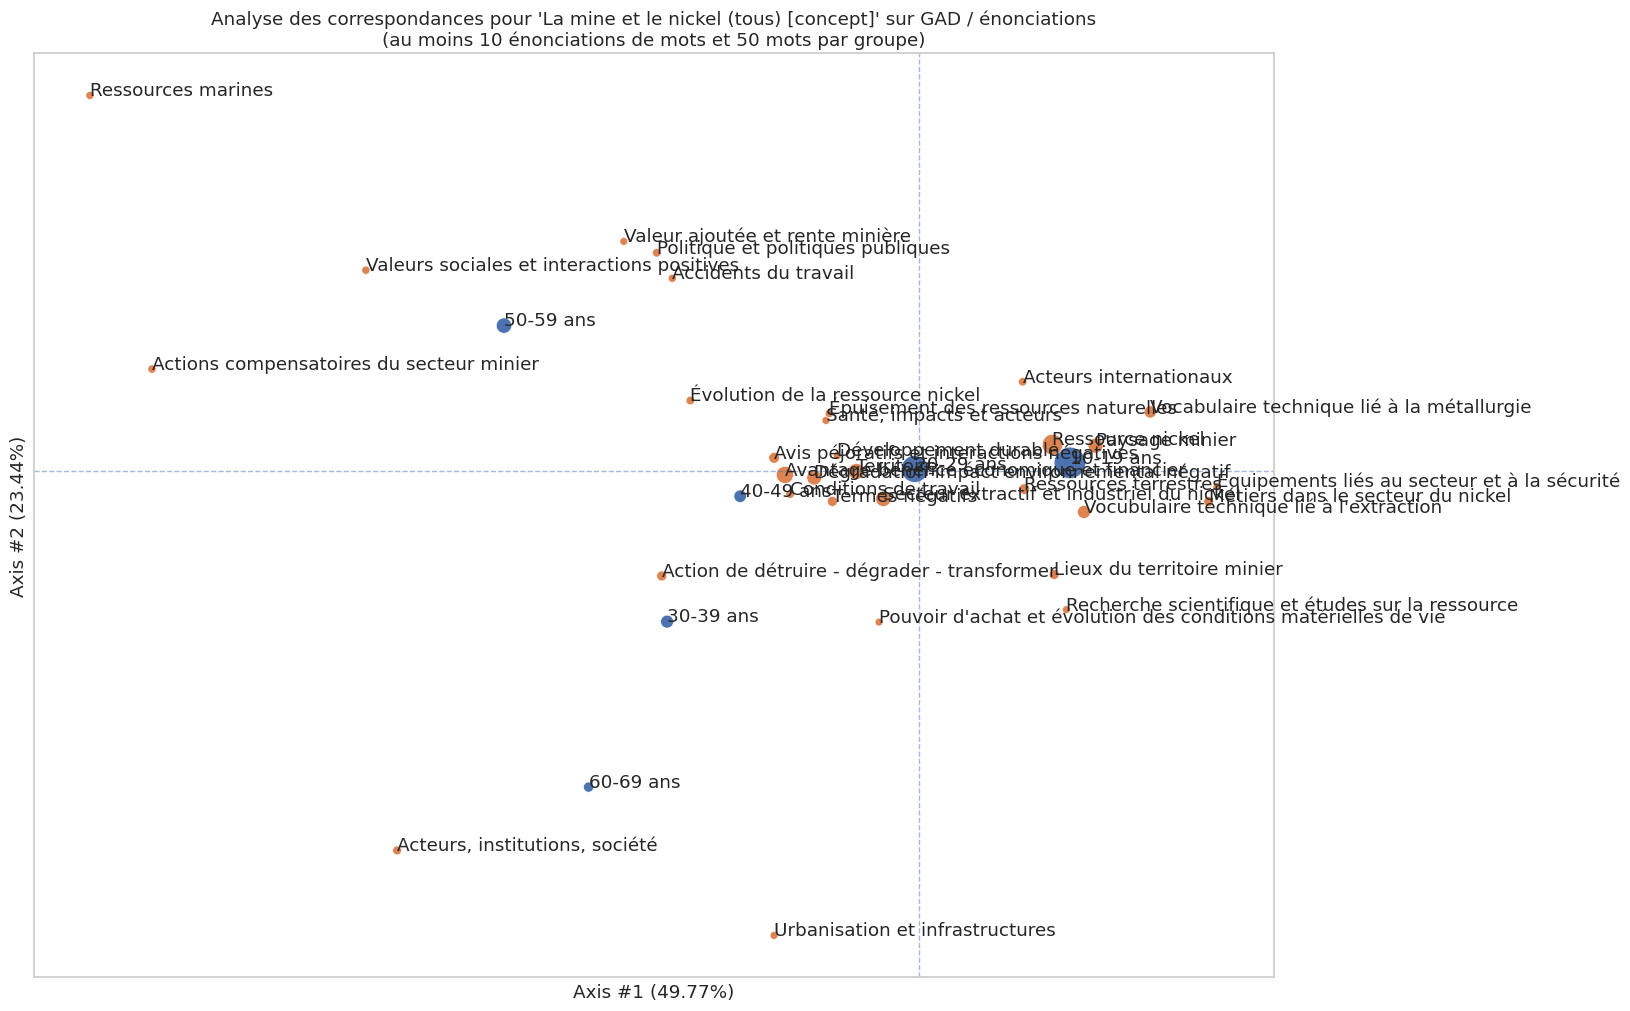

Commune de résidence.,Bourail,Dumbéa,Hienghène,Koné,Lifou,Mont-Dore,Nouméa,Païta,Thio,Yaté
Mot énoncé,,,,,,,,,,
Dégradation-impact environnemental négatif,5,37,44,7,6,55,67,20,13,17
Secteur extractif et industriel du nickel,7,46,41,4,4,65,86,20,11,18
Avantage-bénéfice économique et financier,6,59,49,8,11,64,108,39,18,31
Ressource nickel,11,90,86,9,14,137,180,35,7,24
Termes négatifs,0,6,3,1,2,19,27,7,5,2
Action de détruire - dégrader - transformer,2,12,13,2,2,15,14,4,2,3
"Acteurs, institutions, société",0,1,6,1,1,7,8,2,2,7
Territoire,6,46,58,8,10,50,78,33,11,24
Actions compensatoires du secteur minier,1,3,2,2,0,4,4,0,2,2


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.037538,122.860436,28.791188,28.791188
2,0.033153,108.510845,25.428496,54.219684
3,0.015477,50.656528,11.870881,66.090565
4,0.014249,46.636844,10.928906,77.019471
5,0.011523,37.713160,8.837725,85.857196
6,0.007863,25.736250,6.031048,91.888244
7,0.004887,15.996065,3.748527,95.636772
8,0.003983,13.036101,3.054888,98.691659
9,0.001706,5.583073,1.308341,100.000000


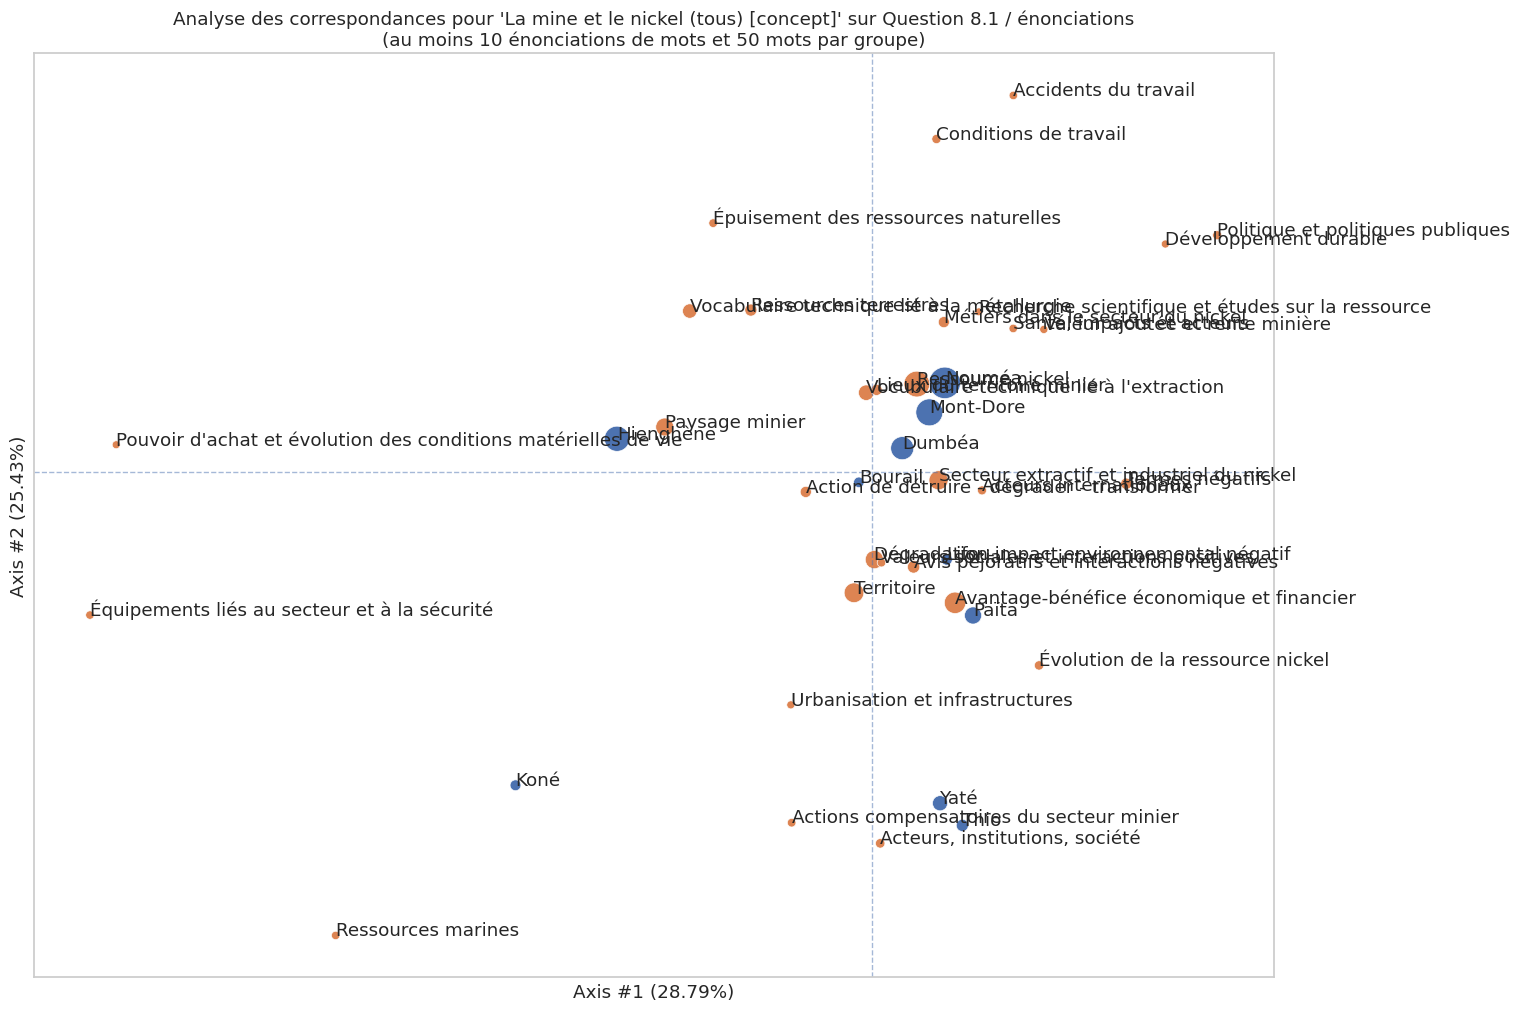

GAD,10-19 ans,20-29 ans,30-39 ans,50-59 ans,60-69 ans
Mot énoncé,,,,,
Territoire,32,8,3,9,4
Dégradation-impact environnemental négatif,28,2,6,5,2
Secteur extractif et industriel du nickel,29,0,1,4,3
Action de détruire - dégrader - transformer,2,2,3,5,4
Paysage minier,76,3,1,2,0
Valeurs sociales et interactions positives,2,0,0,3,0
Actions compensatoires du secteur minier,1,0,3,1,0
Avantage-bénéfice économique et financier,25,6,7,8,3
Diversification,0,0,1,1,1


,Inertia (abs),Chi²,Inertia (%),Cumulated (%)
Axes,,,,
1,0.304616,171.498567,57.451842,57.451842
2,0.115321,64.925633,21.750020,79.201861
3,0.070175,39.508278,13.235232,92.437093
4,0.040099,22.575911,7.562907,100.000000


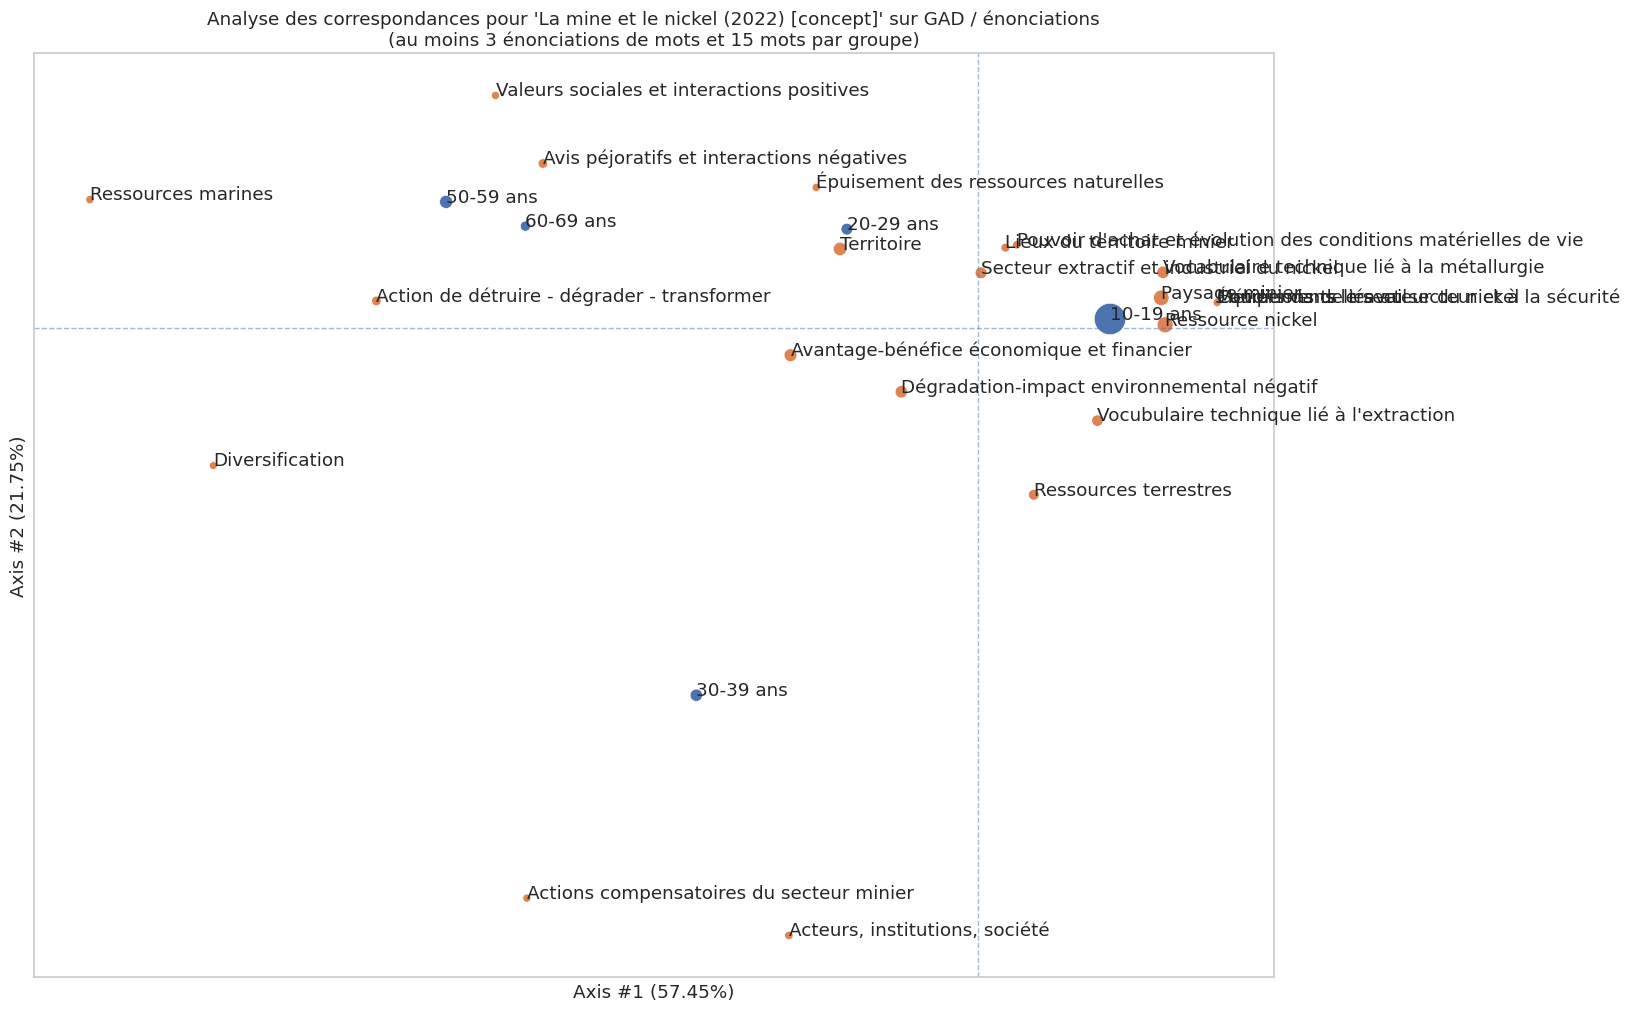

Commune de résidence.,Hienghène,Touho
Mot énoncé,,
Territoire,53,4
Dégradation-impact environnemental négatif,43,2
Secteur extractif et industriel du nickel,38,1
Action de détruire - dégrader - transformer,13,1
Paysage minier,74,6
Valeurs sociales et interactions positives,4,0
Actions compensatoires du secteur minier,2,1
Avantage-bénéfice économique et financier,46,3
Diversification,4,0


Impossible de représenter : pas assez de données pour la mine et le nickel (2022) [concept] de dimension 22x2


GAD,10-19 ans
Mot énoncé,
Secteur extractif et industriel du nickel,8
Champ lexical de l'incertitude,0
Ressource nickel,18
Évolution de la ressource nickel,4
Territoire,7
Épuisement des ressources naturelles,6
Dégradation-impact environnemental négatif,22
Vocubulaire technique lié à l'extraction,8
Vocabulaire technique lié à la métallurgie,4


Impossible de représenter : pas assez de données pour la mine dans le futur (2022) [concept] de dimension 12x1


Commune de résidence.,Hienghène,Touho
Mot énoncé,,
Secteur extractif et industriel du nickel,7,2
Champ lexical de l'incertitude,8,0
Ressource nickel,18,2
Évolution de la ressource nickel,4,2
Territoire,7,3
Épuisement des ressources naturelles,7,1
Dégradation-impact environnemental négatif,18,5
Vocubulaire technique lié à l'extraction,6,2
Vocabulaire technique lié à la métallurgie,3,1


Impossible de représenter : pas assez de données pour la mine dans le futur (2022) [concept] de dimension 12x2


In [23]:
MIN_ROWS = (10, 3, 3)
MIN_COLS = (50, 15, 15)


# for cg, lbl, row, col in zip(CGS, LABELS, MIN_ROWS, MIN_COLS):
#     df = gen_ca_dataset(cg, "GAD", row, col)
#     display(df)


for cg, lbl, row, col in zip(CGS_CON, LABELS_CON, MIN_ROWS, MIN_COLS):
    for attribut in ["GAD", "Question 8.1"]:  # , 
        df_distribution = gen_ca_dataset(cg, attribut, row, col)
        display(df_distribution)
        if len(df_distribution.columns) <= 2 or len(df_distribution) <= 2:
            print(
                f"Impossible de représenter : pas assez de données pour {lbl} de dimension {len(df_distribution)}x{len(df_distribution.columns)}"
            )
            continue
        # display(ref.sort_index())
        ca.fit(df_distribution)
        display(ca.axes())
        ca.plot(coords=("principal", "principal"), legend=None).set(
            title=f"Analyse des correspondances pour '{lbl.capitalize()}' sur {attribut} / énonciations\n(au moins {row} énonciations de mots et {col} mots par groupe)"
        )
        plt.show()


### Distribution concepts




Distribution des énonciations pour 'La mine et le nickel (tous) [concept]'


,nb occurrences,total mots,% total mots,total énonciations,% total énonciations,nb mots,% nb mots,mots,derivée,derivée 2nd
0,2,37,100.0,3715,100.0,2,5.4,"[Lieux du territoire non minier, Termes positifs]",NaN,NaN
1,3,35,94.6,3711,99.9,1,2.7,[Références cinématographiques autour du thème...,-0.100000,NaN
2,5,34,91.9,3708,99.8,1,2.7,[Avis ambivalent],-0.050000,0.025000
3,6,33,89.2,3703,99.7,1,2.7,[Champ lexical de l'incertitude],-0.100000,-0.050000
4,10,32,86.5,3697,99.5,1,2.7,[Diversification],-0.050000,0.012500
5,11,31,83.8,3687,99.2,2,5.4,[Pouvoir d'achat et évolution des conditions m...,-0.300000,-0.250000
6,12,29,78.4,3665,98.7,1,2.7,[Urbanisation et infrastructures],-0.500000,-0.200000
7,13,28,75.7,3653,98.3,1,2.7,[Valeur ajoutée et rente minière],-0.400000,0.100000
8,14,27,73.0,3640,98.0,1,2.7,[Développement durable],-0.300000,0.100000
9,20,26,70.3,3626,97.6,3,8.1,"[Accidents du travail, Ressources marines, San...",-0.066667,0.038889


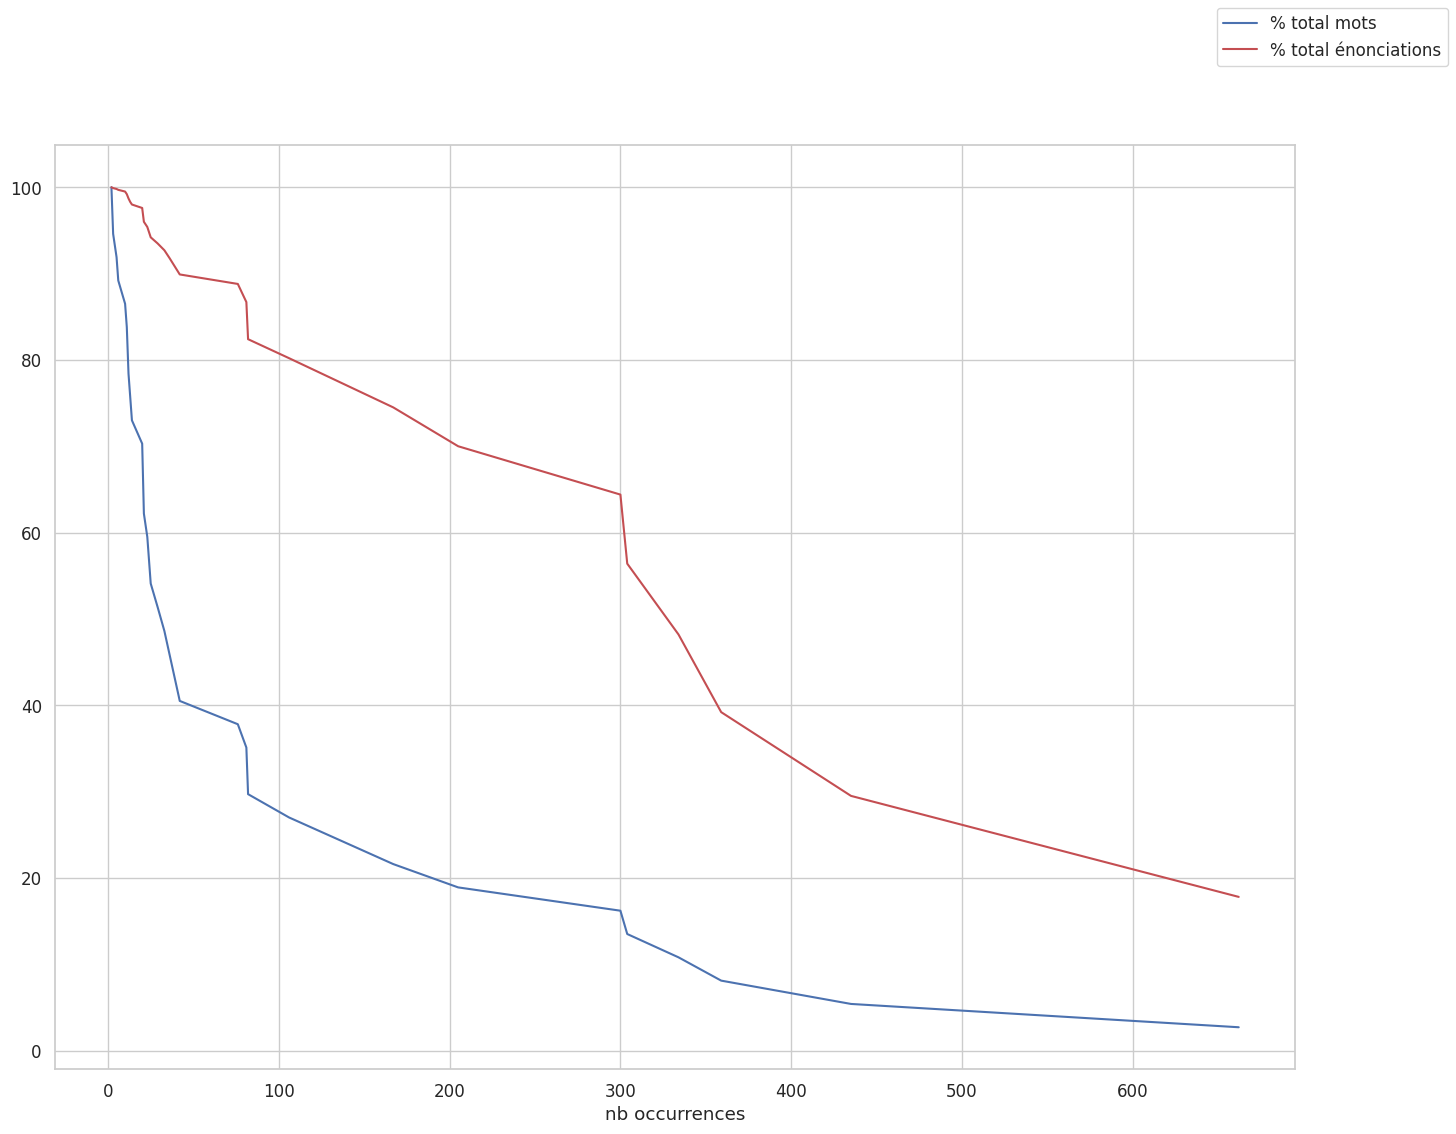

Distribution des énonciations pour 'La mine et le nickel (2022) [concept]'


,nb occurrences,total mots,% total mots,total énonciations,% total énonciations,nb mots,% nb mots,mots,derivée,derivée 2nd
0,1,33,100.0,599,100.0,4,12.1,"[Champ lexical de l'incertitude, Recherche sci...",NaN,NaN
1,2,29,87.9,595,99.3,6,18.2,"[Accidents du travail, Lieux du territoire non...",-0.700000,NaN
2,3,23,69.7,583,97.3,1,3.0,[Acteurs internationaux],-2.000000,-1.300000
3,4,22,66.7,580,96.8,1,3.0,[Diversification],-0.500000,1.500000
4,5,21,63.6,576,96.2,3,9.1,"[Actions compensatoires du secteur minier, Con...",-0.600000,-0.100000
5,6,18,54.5,561,93.7,3,9.1,[Pouvoir d'achat et évolution des conditions m...,-2.500000,-1.900000
6,7,15,45.5,543,90.7,1,3.0,"[Acteurs, institutions, société]",-3.000000,-0.500000
7,8,14,42.4,536,89.5,1,3.0,[Équipements liés au secteur et à la sécurité],-1.200000,1.800000
8,10,13,39.4,528,88.1,1,3.0,[Métiers dans le secteur du nickel],-0.700000,0.250000
9,14,12,36.4,518,86.5,1,3.0,[Lieux du territoire minier],-0.400000,0.075000


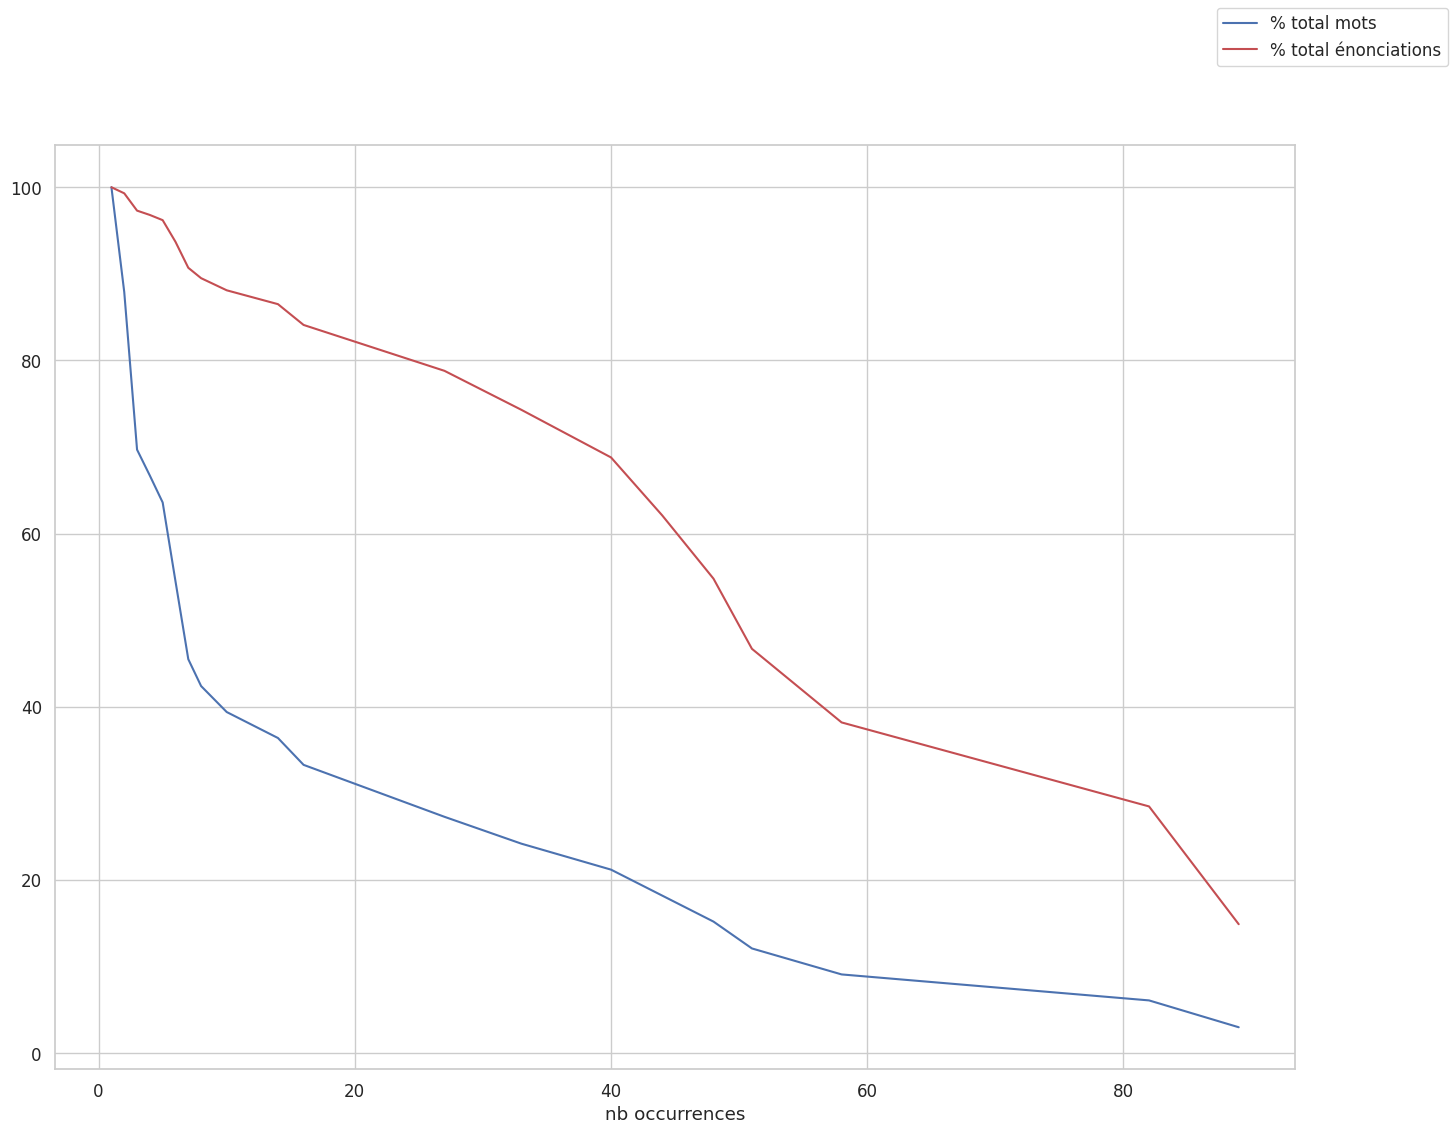

Distribution des énonciations pour 'La mine dans le futur (2022) [concept]'


,nb occurrences,total mots,% total mots,total énonciations,% total énonciations,nb mots,% nb mots,mots,derivée,derivée 2nd
0,1,27,100.0,147,100.0,7,25.9,"[Acteurs, institutions, société, Actions compe...",NaN,NaN
1,2,20,74.1,140,95.2,4,14.8,"[Métiers dans le secteur du nickel, Politique ...",-4.800000,NaN
2,3,16,59.3,132,89.8,4,14.8,"[Action de détruire - dégrader - transformer, ...",-5.400000,-0.600000
3,4,12,44.4,120,81.6,2,7.4,"[Avantage-bénéfice économique et financier, Vo...",-8.200000,-2.800000
4,6,10,37.0,112,76.2,1,3.7,[Évolution de la ressource nickel],-2.700000,2.750000
5,7,9,33.3,106,72.1,1,3.7,[Termes négatifs],-4.100000,-1.400000
6,8,8,29.6,99,67.3,3,11.1,"[Champ lexical de l'incertitude, Vocubulaire t...",-4.800000,-0.700000
7,10,5,18.5,75,51.0,2,7.4,"[Secteur extractif et industriel du nickel, Te...",-8.150000,-1.675000
8,12,3,11.1,55,37.4,1,3.7,[Paysage minier],-6.800000,0.675000
9,20,2,7.4,43,29.3,1,3.7,[Ressource nickel],-1.012500,0.723438


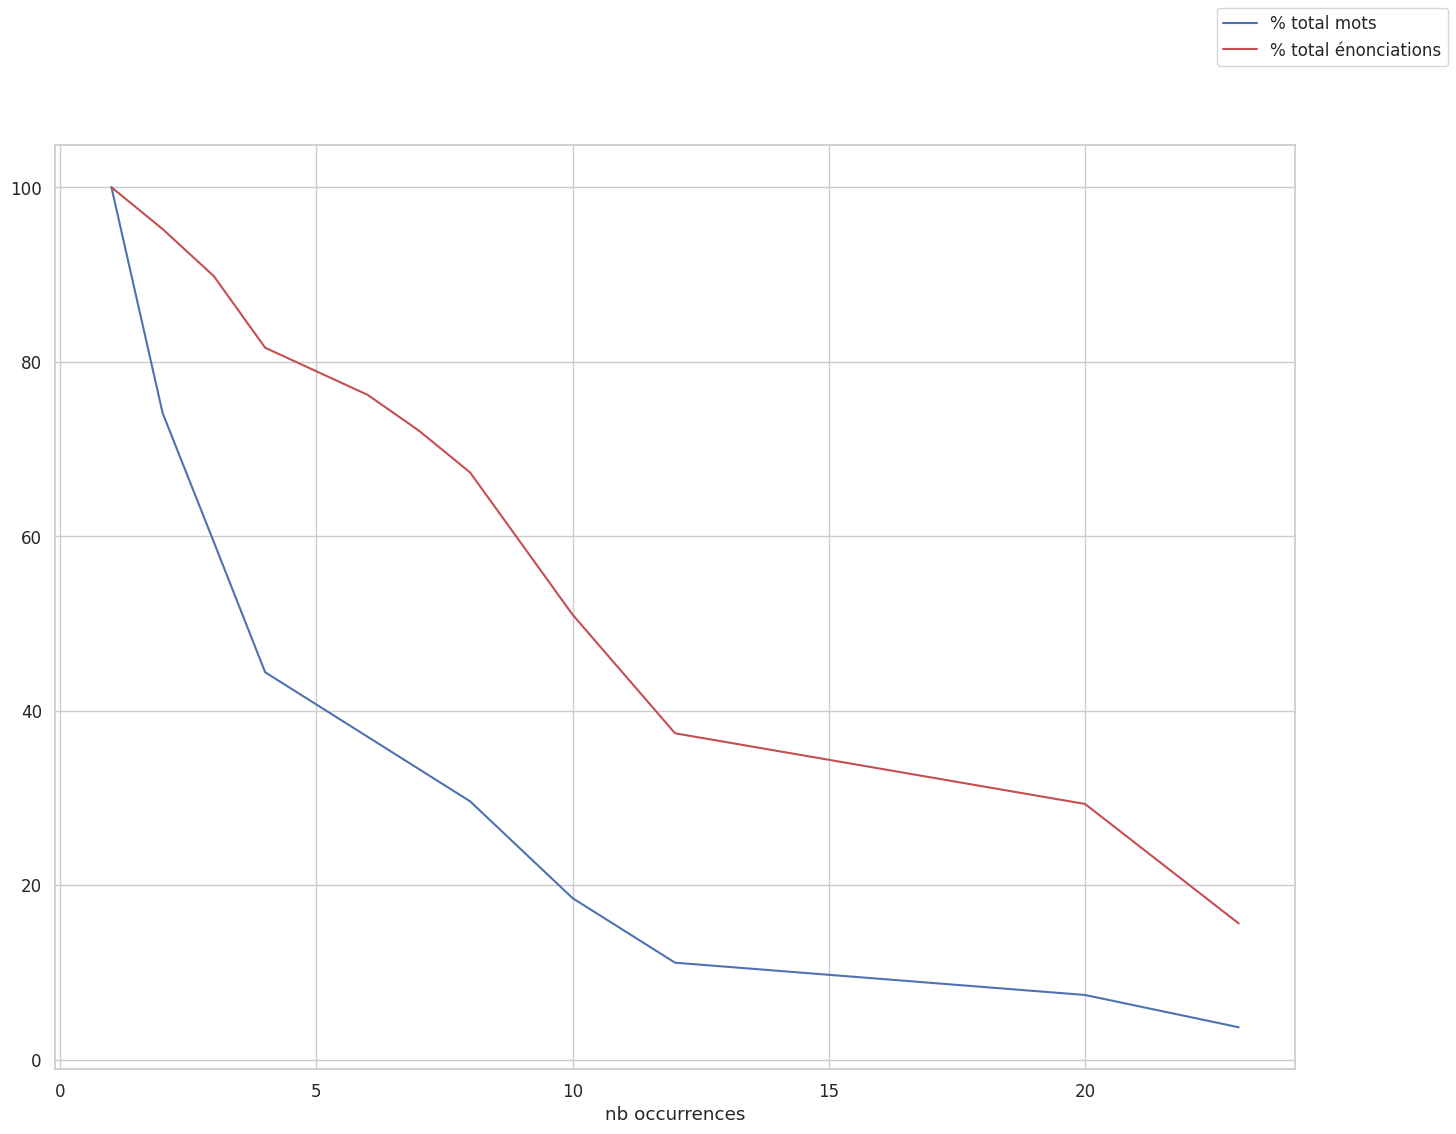

In [24]:
for pos, lbl in zip(POS_CON, LABELS_CON):
    df_distribution = generate_distribution(pos, lbl)
    print(df_distribution.name)
    display(df_distribution)
    ax = df_distribution.plot(x="nb occurrences", y="% total mots", legend=False)
    df_distribution.plot(x="nb occurrences", y="% total énonciations", ax=ax, legend=False, color="r")
    ax.figure.legend()
    plt.show(ax)


### Listes d'Abric sur les concepts

In [25]:
for p, l, rc, cc in zip(POS_CON, LABELS_CON, (310, 60, 30), [50]*3):
    res = split_df(p, rc, cc)
    print(f"Diagramme d'Abric pour '{l.capitalize()}'")
    for freq, row in res.items():
        for imp, df in row.items() :
            print(f"{freq.title()} et {imp.title()}")
            display(df)

Diagramme d'Abric pour 'La mine et le nickel (tous) [concept]'
Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Ressource nickel,662,66.67,63.81
Avantage-bénéfice économique et financier,435,63.64,61.95
Territoire,359,60.00,58.38
Secteur extractif et industriel du nickel,334,57.14,55.35


Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"


Non Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Paysage minier,304,62.50,61.12
Dégradation-impact environnemental négatif,300,57.14,55.84
Vocubulaire technique lié à l'extraction,205,60.00,59.72
Vocabulaire technique lié à la métallurgie,167,50.00,55.50
Ressources terrestres,106,55.56,56.86
Action de détruire - dégrader - transformer,81,54.55,52.61
Lieux du territoire minier,81,62.50,58.38
Valeur ajoutée et rente minière,13,55.56,54.11
Urbanisation et infrastructures,12,50.00,51.47
Diversification,10,50.00,50.57


Non Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Avis péjoratifs et interactions négatives,106,37.50,42.48
Termes négatifs,82,47.73,49.51
Métiers dans le secteur du nickel,76,45.80,49.26
"Acteurs, institutions, société",42,45.80,46.33
Évolution de la ressource nickel,36,29.29,40.72
Conditions de travail,36,44.76,49.50
Politique et politiques publiques,33,40.00,41.91
Acteurs internationaux,29,35.71,44.29
Équipements liés au secteur et à la sécurité,25,33.33,37.01
Valeurs sociales et interactions positives,23,33.33,37.19


Diagramme d'Abric pour 'La mine et le nickel (2022) [concept]'
Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Ressource nickel,89,66.67,65.89
Paysage minier,82,68.63,66.26


Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"


Non Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Territoire,58,63.33,62.24
Avantage-bénéfice économique et financier,51,60.00,59.52
Dégradation-impact environnemental négatif,48,59.41,59.55
Vocabulaire technique lié à la métallurgie,44,50.00,57.02
Secteur extractif et industriel du nickel,40,57.14,54.54
Vocubulaire technique lié à l'extraction,33,52.94,53.72
Ressources terrestres,27,50.00,55.67
Action de détruire - dégrader - transformer,16,57.14,56.15
Lieux du territoire minier,14,55.00,51.73
Métiers dans le secteur du nickel,10,65.00,54.26


Non Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Avis péjoratifs et interactions négatives,16,45.00,51.26
Équipements liés au secteur et à la sécurité,8,38.75,37.51
"Acteurs, institutions, société",7,25.00,38.60
Pouvoir d'achat et évolution des conditions matérielles de vie,6,31.11,39.52
Épuisement des ressources naturelles,6,31.11,40.13
Actions compensatoires du secteur minier,5,25.00,36.57
Acteurs internationaux,3,30.00,33.33
"Santé, impacts et acteurs",2,30.56,30.56
Termes négatifs,2,41.67,41.67
Accidents du travail,2,33.19,33.19


Diagramme d'Abric pour 'La mine dans le futur (2022) [concept]'
Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"


Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"


Non Fréquent et Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Dégradation-impact environnemental négatif,23,66.67,68.65
Ressource nickel,20,77.50,72.71
Paysage minier,12,66.67,69.15
Secteur extractif et industriel du nickel,10,95.45,78.76
Territoire,10,70.83,69.66
Champ lexical de l'incertitude,8,100.00,100.00
Épuisement des ressources naturelles,8,87.50,78.12
Vocubulaire technique lié à l'extraction,8,70.83,69.32
Évolution de la ressource nickel,6,58.33,57.22
Avantage-bénéfice économique et financier,4,50.00,52.27


Non Fréquent et Non Important


,"(*, *, Nb. occ.)","(*, *, Pos. médiane)","(*, *, Pos. moyenne)"
Termes négatifs,7,33.33,49.29
Vocabulaire technique lié à la métallurgie,4,34.85,37.07
Ressources terrestres,3,33.33,49.21
Valeurs sociales et interactions positives,2,45.00,45.00
"Santé, impacts et acteurs",1,20.00,20.00
Diversification,1,33.33,33.33
Pouvoir d'achat et évolution des conditions matérielles de vie,1,25.00,25.00


## Utilisation des super-concepts du thésaurus

On rajoute le niveau des _supers concepts_ **Positifs**, **Négatifs** et **Ambivalent** ou chacun regroupe un sous-ensemble des 38 concepts.

In [26]:
super_concepts = {
    "Positif": [
        "Valeurs sociales et interactions positives",
        "Avantage-bénéfice économique et financier",
        "Termes positifs",
        "Actions compensatoires du secteur minier",
    ],
    "Négatif": [
        "Avis péjoratifs et interactions négatives",
        "Épuisement des ressources naturelles",
        "Dégradation-impact environnemental négatif",
        "Action de détruire - dégrader - transformer",
        "Termes négatifs",
    ],
    "Ambivalent": ["Avis ambivalent", "Champ lexical de l'incertitude"],
}

concepts_filtres = [con for ls in super_concepts.values() for con in ls]
super_concepts_app = multi_dict_to_app(super_concepts)
super_concepts_app

{'Valeurs sociales et interactions positives': 'Positif',
 'Avantage-bénéfice économique et financier': 'Positif',
 'Termes positifs': 'Positif',
 'Actions compensatoires du secteur minier': 'Positif',
 'Avis péjoratifs et interactions négatives': 'Négatif',
 'Épuisement des ressources naturelles': 'Négatif',
 'Dégradation-impact environnemental négatif': 'Négatif',
 'Action de détruire - dégrader - transformer': 'Négatif',
 'Termes négatifs': 'Négatif',
 'Avis ambivalent': 'Ambivalent',
 "Champ lexical de l'incertitude": 'Ambivalent'}

In [27]:
super_thesaurus = {r : ls for concept, ls in thesaurus.items() if (r:=super_concepts_app.get(concept, None)) is not None}
super_thesaurus
super_thesaurus_app= multi_dict_to_app(super_thesaurus)
super_thesaurus_app

{'dégât': 'Négatif',
 'problème': 'Négatif',
 'éloignement': 'Négatif',
 'interdiction': 'Négatif',
 'ruine': 'Négatif',
 'abandon': 'Négatif',
 'chute': 'Négatif',
 'déclin': 'Négatif',
 'perdition': 'Négatif',
 'fin': 'Négatif',
 'néant': 'Négatif',
 'vide': 'Négatif',
 'sans avenir': 'Négatif',
 'catastrophe': 'Négatif',
 'désastre': 'Négatif',
 'dévastateur': 'Négatif',
 'anéantissement': 'Négatif',
 'préjudice': 'Négatif',
 'bouleversement': 'Négatif',
 'effondrement': 'Négatif',
 'perturbation': 'Négatif',
 'instable': 'Négatif',
 'mort': 'Négatif',
 'arme': 'Négatif',
 'bombe': 'Négatif',
 'insécurité': 'Négatif',
 'plainte': 'Négatif',
 'violence': 'Négatif',
 'chaos': 'Négatif',
 'guerre': 'Négatif',
 'guerre civile': 'Négatif',
 'menace': 'Négatif',
 'pire': 'Négatif',
 'survivre': 'Négatif',
 'défaillance': 'Négatif',
 'bruyant': 'Négatif',
 'dérangement': 'Négatif',
 'nuisance': 'Négatif',
 'sale': 'Négatif',
 'saleté': 'Négatif',
 'carence': 'Négatif',
 'manque': 'Négatif'

In [28]:

cg_mine_tous_sup = apply_thesaurus(cg_mine_tous, super_thesaurus_app)
cg_mine_2022_sup = apply_thesaurus(cg_mine_2022, super_thesaurus_app)
cg_futur_2022_sup = apply_thesaurus(cg_futur_2022, super_thesaurus_app)

CGS_SUP = [cg_mine_tous_sup, cg_mine_2022_sup, cg_futur_2022_sup]
LABELS_SUP = [f"{l} [super-concept]" for l in LABELS]


for cg, lbl in zip(CGS_SUP, LABELS_SUP):
    print(lbl.capitalize())
    print(f"  nombre de réponses {len(cg)}")
    print(f"  plus longue cartes {max(len(val) for val in cg.values())}")
    print(f"  longueur moyenne des cartes {fmean(len(val) for val in cg.values()):.2f}")
    print(f"  nombre total de super-concepts énoncés {sum(len(val) for val in cg.values())}")
    print(f"  nombre de super-concepts différents {len(set(v for val in cg.values() for v in val))}")
    print()


pos_mine_tous_sup = get_positions(cg_mine_tous_sup)
pos_mine_2022_sup = get_positions(cg_mine_2022_sup)
pos_futur_2022_sup = get_positions(cg_futur_2022_sup)


POS_SUP = [pos_mine_tous_sup, pos_mine_2022_sup, pos_futur_2022_sup]

# len(pos_mine_tous["nickel"])
print("Position relative maximum, moyenne, mediane et minimum de chaque super-concept")
for w, ps in pos_mine_tous_con.items():
    print(f"\t{w} ({len(ps)}): {max(ps):.0%}, {fmean(ps):.0%}, {median(ps):.0%}, {min(ps):.0%}")


La mine et le nickel (tous) [super-concept]
  nombre de réponses 508
  plus longue cartes 4
  longueur moyenne des cartes 0.18
  nombre total de super-concepts énoncés 90
  nombre de super-concepts différents 3

La mine et le nickel (2022) [super-concept]
  nombre de réponses 104
  plus longue cartes 2
  longueur moyenne des cartes 0.04
  nombre total de super-concepts énoncés 4
  nombre de super-concepts différents 3

La mine dans le futur (2022) [super-concept]
  nombre de réponses 104
  plus longue cartes 2
  longueur moyenne des cartes 0.14
  nombre total de super-concepts énoncés 15
  nombre de super-concepts différents 2

Position relative maximum, moyenne, mediane et minimum de chaque super-concept
	Dégradation-impact environnemental négatif (300): 100%, 56%, 57%, 8%
	Secteur extractif et industriel du nickel (334): 100%, 55%, 57%, 7%
	Avantage-bénéfice économique et financier (435): 100%, 62%, 64%, 7%
	Ressource nickel (662): 100%, 64%, 67%, 7%
	Termes négatifs (82): 100%, 50%,